<a href="https://colab.research.google.com/github/willystumblr/MySolar-ESS/blob/main/solar_energy_predict/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import math
import os
import glob

%matplotlib inline

In [2]:
PATH = '/content/drive/MyDrive/Colab Notebooks/EMS/*/data.csv'
data_csv = {}

for place in sorted(glob.glob(PATH)):
    building = place.split("/")[6]

    data_csv[building] = pd.read_csv(place)

In [3]:
data_csv.keys()

dict_keys(['LG도서관', '기숙사B동', '다산빌딩', '대학C동', '동물실험동', '산업협력관', '삼성환경동', '시설관리동', '신재생에너지동', '중앙도서관', '중앙창고', '축구장', '학사과정', '학생회관'])

In [4]:
for df in data_csv:
    data_csv[df] = data_csv[df].drop(axis=1, columns="누적발전량(kWh)")

In [5]:
for dframe in data_csv:
    
    data_csv[dframe]["일시"] = pd.to_datetime(data_csv[dframe]["일시"])
    print("To Datetime")

To Datetime
To Datetime
To Datetime
To Datetime
To Datetime
To Datetime
To Datetime
To Datetime
To Datetime
To Datetime
To Datetime
To Datetime
To Datetime
To Datetime


In [6]:
# df = data_csv["LG도서관"]
Features_list = {}
# print(df['Hour'].unique())
for df in data_csv:
    Features = data_csv[df] ['Hour']
    enc = preprocessing.LabelEncoder()
    enc.fit(Features)
    Features = enc.transform(Features)
    print(Features)
    Features_list[df] = Features

[ 0  1  2 ... 21 22 23]
[ 0  1  2 ... 21 22 23]
[ 0  1  2 ... 21 22 23]
[ 0  1  2 ... 21 22 23]
[ 0  1  2 ... 21 22 23]
[ 0  1  2 ... 21 22 23]
[ 0  1  2 ... 21 22 23]
[ 0  1  2 ... 21 22 23]
[ 0  1  2 ... 21 22 23]
[ 0  1  2 ... 21 22 23]
[ 0  1  2 ... 21 22 23]
[ 0  1  2 ... 21 22 23]
[ 0  1  2 ... 21 22 23]
[ 0  1  2 ... 21 22 23]


In [7]:
for features in Features_list:

    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(Features_list[features].reshape(-1,1))
    # print(Features.reshape(-1,1))
    Features_list[features] = encoded.transform(Features_list[features].reshape(-1,1)).toarray()
    # Features_list[features][:10,:]

In [8]:
def encode_string(cat_feature):
    ## First encode the strings to numeric categories
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_feature)
    enc_cat_feature = enc.transform(cat_feature)
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(enc_cat_feature.reshape(-1,1))
    return encoded.transform(enc_cat_feature.reshape(-1,1)).toarray()
    

categorical_columns = ['Cloud']

for feature in Features_list:
    for col in categorical_columns:
        temp = encode_string(data_csv[feature][col])
        Features_list[feature] = np.concatenate([Features_list[feature], temp], axis = 1)
        #print(Features)

print(Features_list[feature].shape)
#print(Features[:2, :])

(18096, 26)


In [9]:
for feature in Features_list:

    Features_list[feature] = np.concatenate([Features_list[feature], np.array(data_csv[feature][['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '증기압(hPa)', '이슬점온도(°C)',
           '일조(hr)', '일사(MJ/m2)', 'Hour', 'Month', 'Day']])], axis = 1)
Features_list[feature][:2,:]

array([[ 1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  1. , 19.5,  0. ,  1.9, 89. , 20.1, 17.6,  0. ,
         0. ,  0. ,  6. ,  1. ],
       [ 0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  1. , 19.3,  0. ,  1.7, 93. , 20.8, 18.1,  0. ,
         0. ,  1. ,  6. ,  1. ]])

In [10]:
Features_list[feature].shape

(18096, 37)

In [11]:
feature

'학생회관'

# Splitting the data

In [12]:
nr.seed(9922)
x_train = {}
y_train = {}
x_test = {}
y_test = {}

for df in data_csv:
    labels = np.array(data_csv[df]['시간당발전량(kWh)'])
    indx = range(Features_list[df].shape[0])
    indx = ms.train_test_split(indx, test_size = 0.25)
    # print(indx)
    x_train[df] = Features_list[df][indx[0],:]
    y_train[df] = np.ravel(labels[indx[0]])
    x_test[df] = Features_list[df][indx[1],:]
    y_test[df] = np.ravel(labels[indx[1]])

In [13]:
len(y_train[df])+len(y_test[df])

18096

In [16]:
x_train['LG도서관'].shape

(13572, 37)

In [19]:
x_test['LG도서관'].shape

(4524, 37)

# Print and Plot

In [17]:
def print_metrics(y_true, y_predicted, n_parameters):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    r2_adj = r2 - (n_parameters - 1)/(y_true.shape[0] - n_parameters) * (1 - r2)
    
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj))
    
    return sklm.mean_squared_error(y_true, y_predicted), r2

In [18]:
def plot_res(y_test, y_score, label_test, label_score, dpi=100):
    plt.figure(figsize=(10,7), dpi=dpi)
    plt.plot(y_test, label=label_test)
    plt.plot(y_score, label=label_score)
    plt.legend(loc=1)
    plt.title('Y test vs. y_predict, lag ' )
    plt.show()

# Model: LSTM

The input to every LSTM layer must be three-dimensional.

The three dimensions of this input are:

* Samples. One sequence is one sample. A batch is comprised of one or more samples.
* Time Steps. One time step is one point of observation in the sample.
* Features. One feature is one observation at a time step.

In [47]:
model_results = {}
for key in data_csv:
    model_results[key] = []

In [22]:
X_train = {}
X_test = {}

for x in x_train:
    X_train[x] = x_train[x].reshape((x_train[x].shape[0], 1, x_train[x].shape[1]))
    X_test[x] = x_test[x].reshape((x_test[x].shape[0], 1, x_test[x].shape[1]))

X_train[x].shape

(13572, 1, 37)

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
import time

In [50]:
def LSTM_model(place, X_train, y_train, X_test, y_test,batch_size_= 12, dropout_=.3,epochs_=10, samples=24):
    

    # comment out this box and uncomment load_model to load saved model
    #################################################################################
                                                                                    #
    # design network                                                                #
    model = Sequential()                                                            #
    model.add(LSTM(int(samples), input_shape=(X_train.shape[1], X_train.shape[2]))) #
    model.add(Dropout(dropout_))                                                    #
    model.add(Dense(1))                                                             #
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    callback = EarlyStopping(monitor='loss', patience=3)                      #
                                                                                    #
    # fit network                                                                   #
    history = model.fit(X_train,                                                    #
                        y_train,                                                    #
                        epochs=epochs_,                                             #
                        batch_size=batch_size_,                                     #
                        validation_data=(X_test, y_test),                           #
                        verbose=1,
                        callbacks=[callback],
                        shuffle=False)                                              #
                                                                                    #
    # Save model for later                                                          #
    filename = str(int(time.time())) + '_model_' + str(samples) + '_lag.h5'         #
    model.save('./models/' + place + "/" +filename)                                              #
                                                                                    #
    #################################################################################


    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.title('Training lag ' + str(samples))
    plt.show()
    
    y_score = model.predict(X_test) 
    y_score = [x if x > 0 else 0 for x in y_score]
    (rmse, r2) = print_metrics(y_test, y_score, 28)
    plot_res(y_test, y_score, label_test = 'y_test', label_score='y_predict')
    
    # Save all the results
    
    model_results_dict = {}

    model_results_dict['Algo'] = 'LSTM'
    model_results_dict['lag'] = samples
    model_results_dict['dropout'] = dropout_
    model_results_dict['epochs'] = epochs_
    model_results_dict['batch_size'] = batch_size_
    model_results_dict['loss'] = history.history
    model_results_dict['rmse'] = rmse
    model_results_dict['power_gen_rmse'] = math.sqrt(rmse)
    model_results_dict['r2'] = r2
    model_results_dict['model_filename'] = filename
    model_results_dict['time_ran'] = int(time.time())

    

    model_results[building].append(model_results_dict)

In [49]:
X_train['기숙사B동'].shape

(12888, 1, 37)

Epoch 1/10
1131/1131 [==============================] - 5s 3ms/step - loss: 73.2448 - val_loss: 37.3093
Epoch 2/10
1131/1131 [==============================] - 4s 3ms/step - loss: 28.7931 - val_loss: 18.1010
Epoch 3/10
1131/1131 [==============================] - 5s 5ms/step - loss: 20.5645 - val_loss: 14.6737
Epoch 4/10
1131/1131 [==============================] - 3s 3ms/step - loss: 18.3557 - val_loss: 13.2608
Epoch 5/10
1131/1131 [==============================] - 3s 3ms/step - loss: 17.5639 - val_loss: 12.7223
Epoch 6/10
1131/1131 [==============================] - 3s 2ms/step - loss: 16.6989 - val_loss: 12.2268
Epoch 7/10
1131/1131 [==============================] - 3s 3ms/step - loss: 16.3530 - val_loss: 12.3021
Epoch 8/10
1131/1131 [==============================] - 3s 3ms/step - loss: 16.1983 - val_loss: 12.0327
Epoch 9/10
1131/1131 [==============================] - 3s 3ms/step - loss: 15.7185 - val_loss: 12.0050
Epoch 10/10
1131/1131 [==============================] - 3s 3ms/

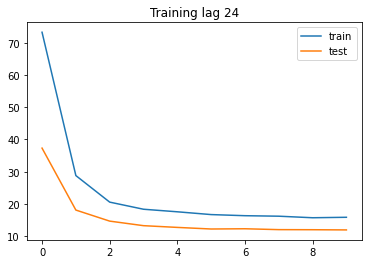

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Mean Square Error      = 11.93947012734114
Root Mean Square Error = 3.4553538353316497
Mean Absolute Error    = 1.773773823421577
Median Absolute Error  = 0.6612231731414795
R^2                    = 0.8764551550644374
Adjusted R^2           = 0.8757132265027692


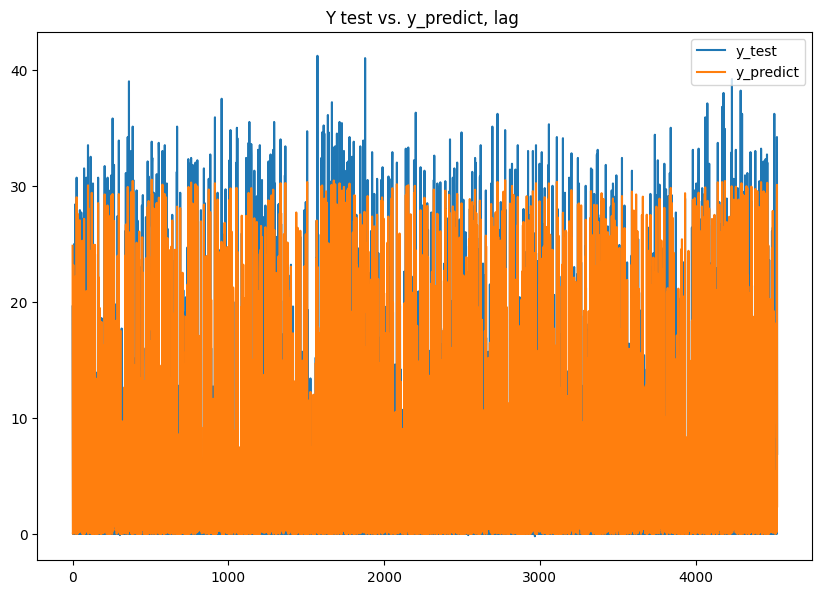

Epoch 1/10
1074/1074 [==============================] - 6s 3ms/step - loss: 111.1126 - val_loss: 87.8878
Epoch 2/10
1074/1074 [==============================] - 3s 3ms/step - loss: 76.1333 - val_loss: 66.3763
Epoch 3/10
1074/1074 [==============================] - 3s 2ms/step - loss: 63.4065 - val_loss: 56.9125
Epoch 4/10
1074/1074 [==============================] - 3s 2ms/step - loss: 57.0294 - val_loss: 52.0544
Epoch 5/10
1074/1074 [==============================] - 3s 2ms/step - loss: 55.0884 - val_loss: 49.5872
Epoch 6/10
1074/1074 [==============================] - 3s 3ms/step - loss: 52.3401 - val_loss: 49.1273
Epoch 7/10
1074/1074 [==============================] - 3s 3ms/step - loss: 51.6047 - val_loss: 47.9927
Epoch 8/10
1074/1074 [==============================] - 3s 3ms/step - loss: 50.0600 - val_loss: 46.2268
Epoch 9/10
1074/1074 [==============================] - 3s 3ms/step - loss: 49.0974 - val_loss: 45.9675
Epoch 10/10
1074/1074 [==============================] - 3s 3ms

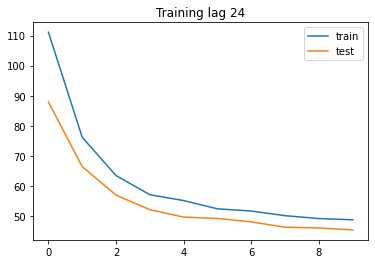

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Mean Square Error      = 46.37349964894793
Root Mean Square Error = 6.809809075807333
Mean Absolute Error    = 3.1477541522329306
Median Absolute Error  = 0.549104022979737
R^2                    = 0.6524699604316504
Adjusted R^2           = 0.6502714339395357


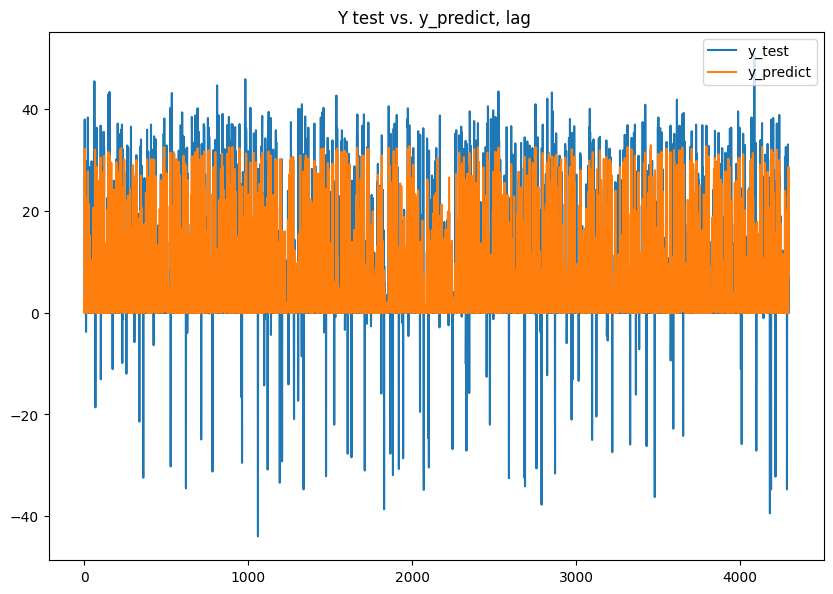

Epoch 1/10
1131/1131 [==============================] - 5s 3ms/step - loss: 56.6653 - val_loss: 29.0931
Epoch 2/10
1131/1131 [==============================] - 3s 3ms/step - loss: 24.1437 - val_loss: 18.3148
Epoch 3/10
1131/1131 [==============================] - 3s 3ms/step - loss: 19.5584 - val_loss: 16.4881
Epoch 4/10
1131/1131 [==============================] - 3s 3ms/step - loss: 18.5497 - val_loss: 15.5247
Epoch 5/10
1131/1131 [==============================] - 3s 3ms/step - loss: 17.8168 - val_loss: 14.9482
Epoch 6/10
1131/1131 [==============================] - 3s 3ms/step - loss: 17.2267 - val_loss: 14.3007
Epoch 7/10
1131/1131 [==============================] - 3s 2ms/step - loss: 16.6400 - val_loss: 14.0524
Epoch 8/10
1131/1131 [==============================] - 3s 3ms/step - loss: 16.5177 - val_loss: 14.0201
Epoch 9/10
1131/1131 [==============================] - 3s 3ms/step - loss: 16.3977 - val_loss: 13.7145
Epoch 10/10
1131/1131 [==============================] - 3s 3ms/

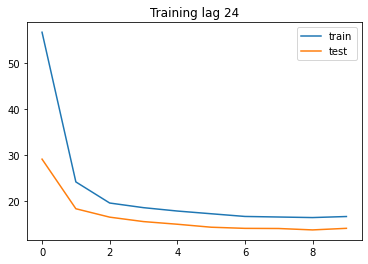

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Mean Square Error      = 14.030311531358079
Root Mean Square Error = 3.745705745431437
Mean Absolute Error    = 1.8548272591397157
Median Absolute Error  = 0.3
R^2                    = 0.7973201336625366
Adjusted R^2           = 0.7961029725435171


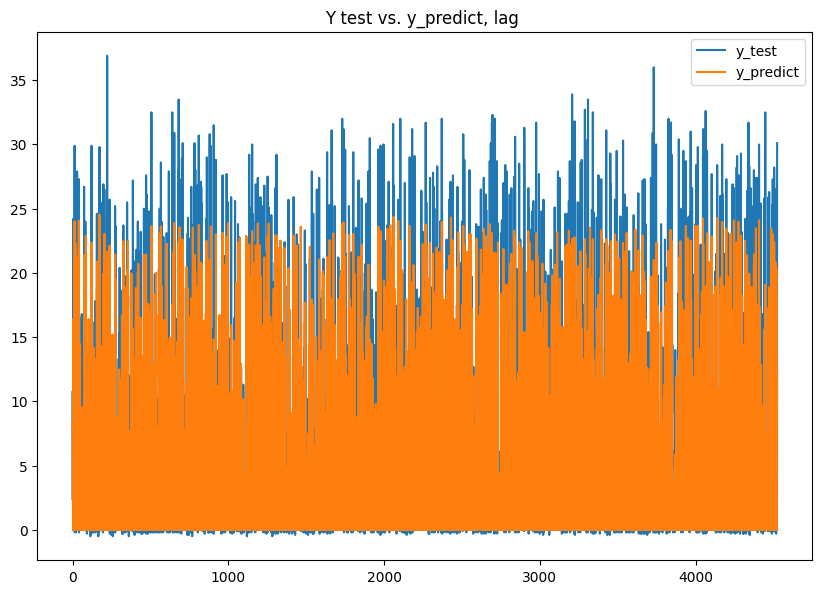

Epoch 1/10
1131/1131 [==============================] - 5s 3ms/step - loss: 5.7254 - val_loss: 2.0252
Epoch 2/10
1131/1131 [==============================] - 3s 3ms/step - loss: 2.1466 - val_loss: 1.5393
Epoch 3/10
1131/1131 [==============================] - 3s 3ms/step - loss: 1.8671 - val_loss: 1.4244
Epoch 4/10
1131/1131 [==============================] - 4s 4ms/step - loss: 1.7594 - val_loss: 1.3933
Epoch 5/10
1131/1131 [==============================] - 3s 3ms/step - loss: 1.7095 - val_loss: 1.3639
Epoch 6/10
1131/1131 [==============================] - 3s 3ms/step - loss: 1.6712 - val_loss: 1.3714
Epoch 7/10
1131/1131 [==============================] - 3s 3ms/step - loss: 1.6712 - val_loss: 1.3232
Epoch 8/10
1131/1131 [==============================] - 3s 3ms/step - loss: 1.6381 - val_loss: 1.3038
Epoch 9/10
1131/1131 [==============================] - 3s 3ms/step - loss: 1.5963 - val_loss: 1.3369
Epoch 10/10
1131/1131 [==============================] - 3s 3ms/step - loss: 1.620

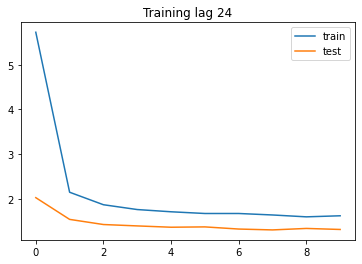

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Mean Square Error      = 1.3127965044202015
Root Mean Square Error = 1.1457733215694113
Mean Absolute Error    = 0.5517140126539268
Median Absolute Error  = 0.13826162219047555
R^2                    = 0.8768182354476435
Adjusted R^2           = 0.876078487306426


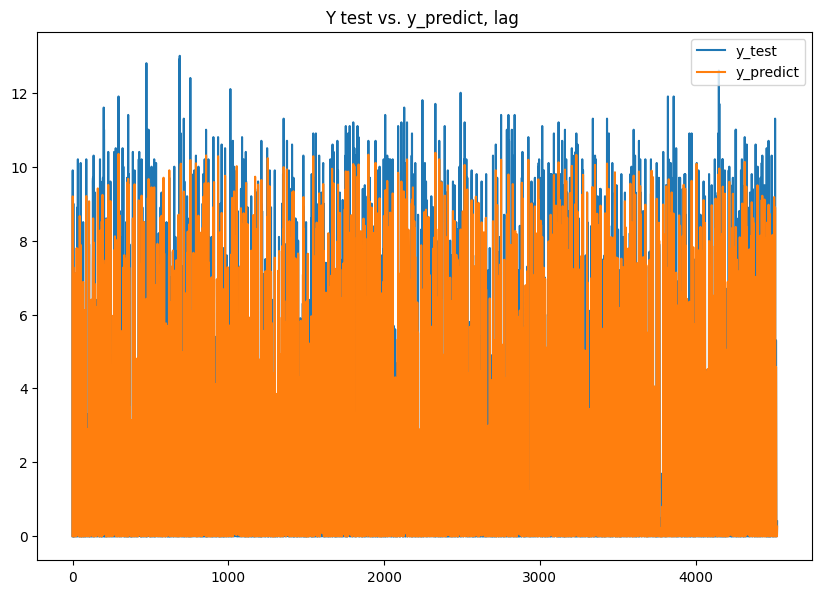

Epoch 1/10
1131/1131 [==============================] - 6s 3ms/step - loss: 59.5094 - val_loss: 26.2742
Epoch 2/10
1131/1131 [==============================] - 3s 3ms/step - loss: 21.6726 - val_loss: 13.4645
Epoch 3/10
1131/1131 [==============================] - 3s 3ms/step - loss: 16.2050 - val_loss: 11.7563
Epoch 4/10
1131/1131 [==============================] - 3s 3ms/step - loss: 14.6268 - val_loss: 10.8180
Epoch 5/10
1131/1131 [==============================] - 3s 3ms/step - loss: 14.1271 - val_loss: 10.6548
Epoch 6/10
1131/1131 [==============================] - 3s 3ms/step - loss: 13.6769 - val_loss: 11.0504
Epoch 7/10
1131/1131 [==============================] - 3s 3ms/step - loss: 13.1373 - val_loss: 10.7236
Epoch 8/10
1131/1131 [==============================] - 3s 3ms/step - loss: 12.9734 - val_loss: 10.7531
Epoch 9/10
1131/1131 [==============================] - 3s 3ms/step - loss: 13.0522 - val_loss: 10.5947
Epoch 10/10
1131/1131 [==============================] - 3s 3ms/

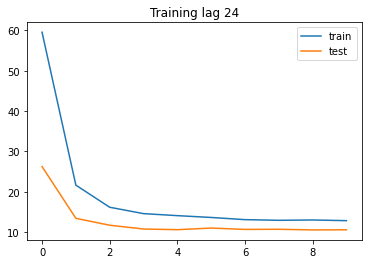

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Mean Square Error      = 10.615210308152063
Root Mean Square Error = 3.258099186358829
Mean Absolute Error    = 1.69545618417672
Median Absolute Error  = 0.5967627763748169
R^2                    = 0.8716335703804922
Adjusted R^2           = 0.8708626865727238


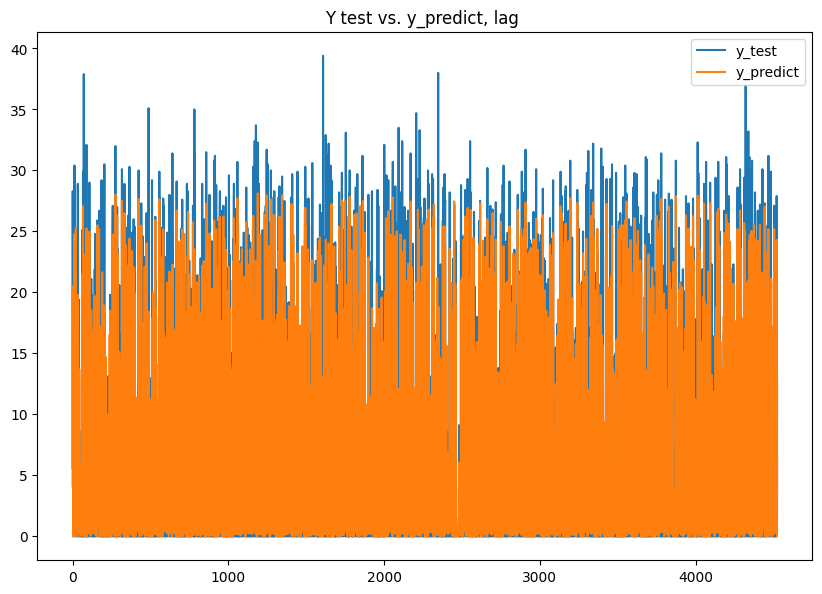

Epoch 1/10
1074/1074 [==============================] - 5s 3ms/step - loss: 603.2195 - val_loss: 487.6040
Epoch 2/10
1074/1074 [==============================] - 3s 3ms/step - loss: 453.2853 - val_loss: 385.8127
Epoch 3/10
1074/1074 [==============================] - 3s 3ms/step - loss: 371.5920 - val_loss: 321.3391
Epoch 4/10
1074/1074 [==============================] - 3s 3ms/step - loss: 329.0123 - val_loss: 289.8695
Epoch 5/10
1074/1074 [==============================] - 3s 3ms/step - loss: 303.5627 - val_loss: 269.3924
Epoch 6/10
1074/1074 [==============================] - 3s 3ms/step - loss: 282.4219 - val_loss: 252.3806
Epoch 7/10
1074/1074 [==============================] - 3s 3ms/step - loss: 267.2072 - val_loss: 244.1609
Epoch 8/10
1074/1074 [==============================] - 4s 4ms/step - loss: 257.9102 - val_loss: 234.9839
Epoch 9/10
1074/1074 [==============================] - 3s 3ms/step - loss: 251.4204 - val_loss: 231.0952
Epoch 10/10
1074/1074 [=======================

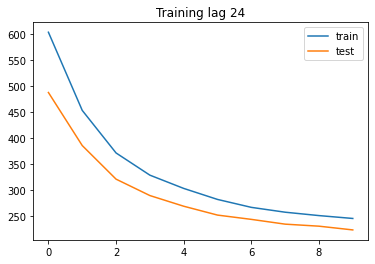

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Mean Square Error      = 224.2098625502572
Root Mean Square Error = 14.973638921459846
Mean Absolute Error    = 7.2226524234650515
Median Absolute Error  = 1.4172791242599487
R^2                    = 0.6187641091508483
Adjusted R^2           = 0.6163523544524118


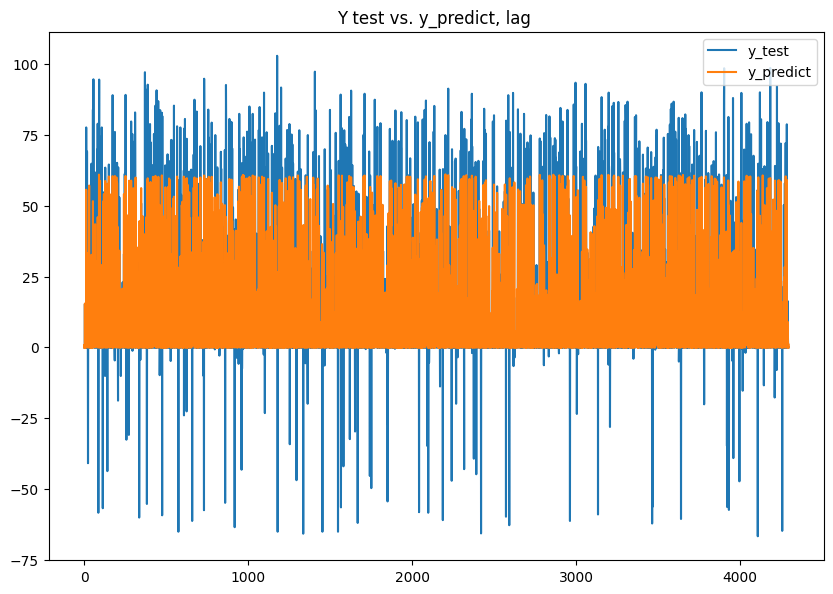

Epoch 1/10
1131/1131 [==============================] - 5s 3ms/step - loss: 161.5600 - val_loss: 88.5844
Epoch 2/10
1131/1131 [==============================] - 3s 3ms/step - loss: 68.4062 - val_loss: 42.3976
Epoch 3/10
1131/1131 [==============================] - 3s 3ms/step - loss: 46.5202 - val_loss: 32.4226
Epoch 4/10
1131/1131 [==============================] - 3s 3ms/step - loss: 41.8420 - val_loss: 27.9865
Epoch 5/10
1131/1131 [==============================] - 3s 3ms/step - loss: 38.5939 - val_loss: 26.3967
Epoch 6/10
1131/1131 [==============================] - 3s 3ms/step - loss: 37.0133 - val_loss: 25.6536
Epoch 7/10
1131/1131 [==============================] - 3s 3ms/step - loss: 35.9024 - val_loss: 25.0473
Epoch 8/10
1131/1131 [==============================] - 3s 3ms/step - loss: 34.5849 - val_loss: 24.9608
Epoch 9/10
1131/1131 [==============================] - 3s 3ms/step - loss: 34.2208 - val_loss: 25.0341
Epoch 10/10
1131/1131 [==============================] - 3s 3ms

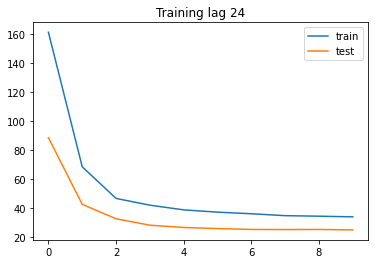

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Mean Square Error      = 24.697564693111175
Root Mean Square Error = 4.969664444719701
Mean Absolute Error    = 2.512520093584777
Median Absolute Error  = 0.845185542106627
R^2                    = 0.8761930374488225
Adjusted R^2           = 0.8754495347822563


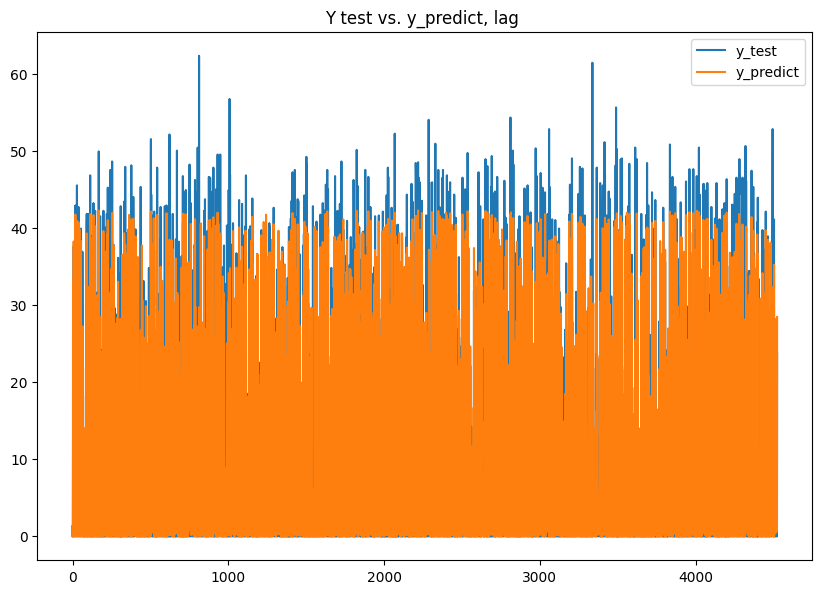

Epoch 1/10
1131/1131 [==============================] - 6s 3ms/step - loss: 762.6002 - val_loss: 621.7538
Epoch 2/10
1131/1131 [==============================] - 3s 3ms/step - loss: 453.8710 - val_loss: 369.9100
Epoch 3/10
1131/1131 [==============================] - 3s 3ms/step - loss: 296.9593 - val_loss: 246.4980
Epoch 4/10
1131/1131 [==============================] - 3s 3ms/step - loss: 221.4365 - val_loss: 191.2860
Epoch 5/10
1131/1131 [==============================] - 3s 3ms/step - loss: 183.5772 - val_loss: 163.2615
Epoch 6/10
1131/1131 [==============================] - 3s 3ms/step - loss: 165.9321 - val_loss: 144.1443
Epoch 7/10
1131/1131 [==============================] - 3s 3ms/step - loss: 159.0444 - val_loss: 132.0384
Epoch 8/10
1131/1131 [==============================] - 3s 3ms/step - loss: 147.9640 - val_loss: 132.2457
Epoch 9/10
1131/1131 [==============================] - 3s 3ms/step - loss: 142.0308 - val_loss: 128.3126
Epoch 10/10
1131/1131 [=======================

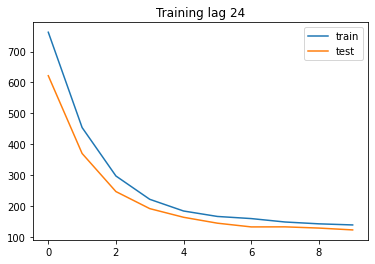

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Mean Square Error      = 121.50633671855981
Root Mean Square Error = 11.022991278167638
Mean Absolute Error    = 5.303222085204829
Median Absolute Error  = 1.1909685134887695
R^2                    = 0.8409109600948508
Adjusted R^2           = 0.8399555766256696


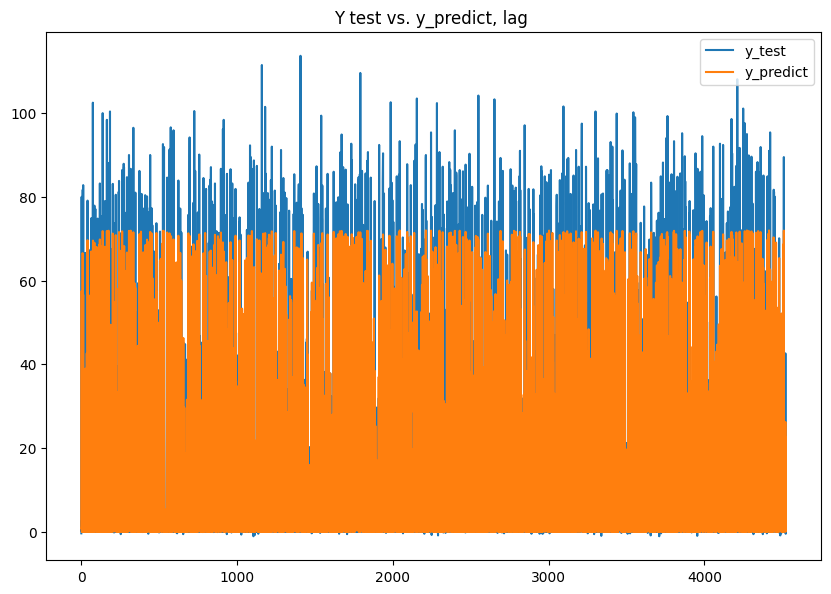

Epoch 1/10
1131/1131 [==============================] - 5s 3ms/step - loss: 216.4464 - val_loss: 130.4071
Epoch 2/10
1131/1131 [==============================] - 3s 3ms/step - loss: 101.6844 - val_loss: 65.4535
Epoch 3/10
1131/1131 [==============================] - 3s 3ms/step - loss: 64.1679 - val_loss: 43.0100
Epoch 4/10
1131/1131 [==============================] - 3s 3ms/step - loss: 51.0804 - val_loss: 36.2344
Epoch 5/10
1131/1131 [==============================] - 3s 3ms/step - loss: 45.6057 - val_loss: 33.2560
Epoch 6/10
1131/1131 [==============================] - 3s 3ms/step - loss: 43.8918 - val_loss: 32.8929
Epoch 7/10
1131/1131 [==============================] - 3s 3ms/step - loss: 41.6821 - val_loss: 30.7202
Epoch 8/10
1131/1131 [==============================] - 3s 3ms/step - loss: 40.1748 - val_loss: 30.5586
Epoch 9/10
1131/1131 [==============================] - 3s 3ms/step - loss: 39.9698 - val_loss: 31.8782
Epoch 10/10
1131/1131 [==============================] - 3s 3

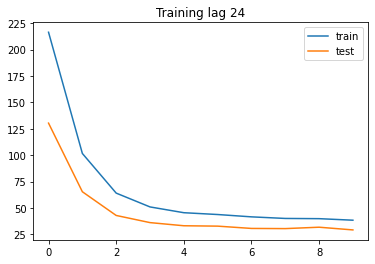

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Mean Square Error      = 29.302176208760294
Root Mean Square Error = 5.41314845619075
Mean Absolute Error    = 2.9293085160084678
Median Absolute Error  = 1.366992092132568
R^2                    = 0.8781270971376401
Adjusted R^2           = 0.8773952091533689


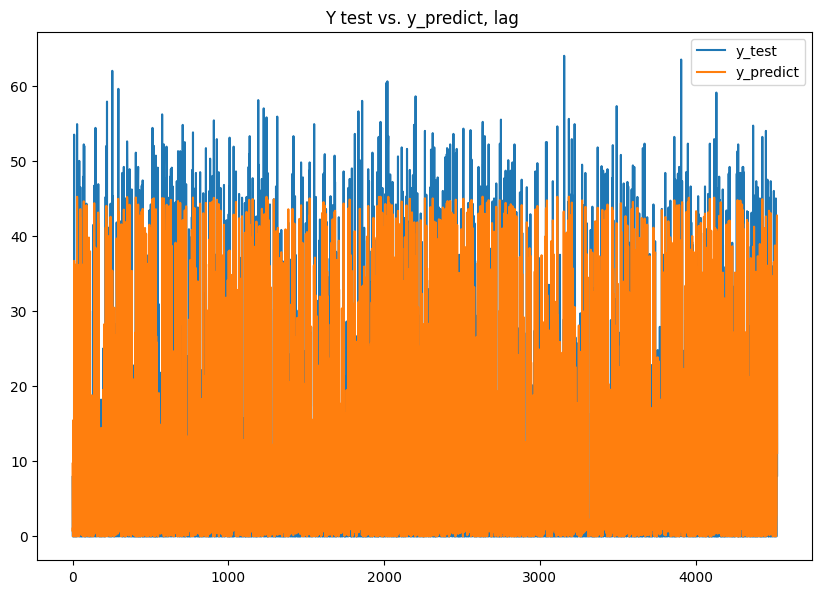

Epoch 1/10
1131/1131 [==============================] - 5s 3ms/step - loss: 32.5487 - val_loss: 14.9251
Epoch 2/10
1131/1131 [==============================] - 3s 3ms/step - loss: 12.0391 - val_loss: 7.7818
Epoch 3/10
1131/1131 [==============================] - 3s 3ms/step - loss: 9.9274 - val_loss: 7.3661
Epoch 4/10
1131/1131 [==============================] - 3s 3ms/step - loss: 9.4323 - val_loss: 7.0966
Epoch 5/10
1131/1131 [==============================] - 3s 3ms/step - loss: 8.8674 - val_loss: 7.1020
Epoch 6/10
1131/1131 [==============================] - 3s 3ms/step - loss: 8.4376 - val_loss: 7.1176
Epoch 7/10
1131/1131 [==============================] - 3s 3ms/step - loss: 8.4890 - val_loss: 6.5506
Epoch 8/10
1131/1131 [==============================] - 3s 3ms/step - loss: 8.4662 - val_loss: 6.3476
Epoch 9/10
1131/1131 [==============================] - 3s 3ms/step - loss: 8.2179 - val_loss: 6.4616
Epoch 10/10
1131/1131 [==============================] - 3s 3ms/step - loss: 8.

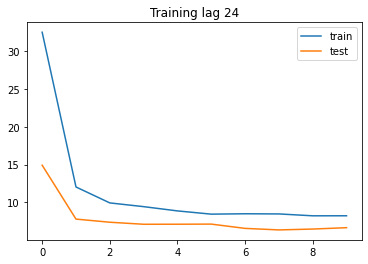

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Mean Square Error      = 6.6427550052594695
Root Mean Square Error = 2.5773542646014866
Mean Absolute Error    = 1.5713100478540576
Median Absolute Error  = 0.9115953683853153
R^2                    = 0.8746267733691275
Adjusted R^2           = 0.8738738647572428


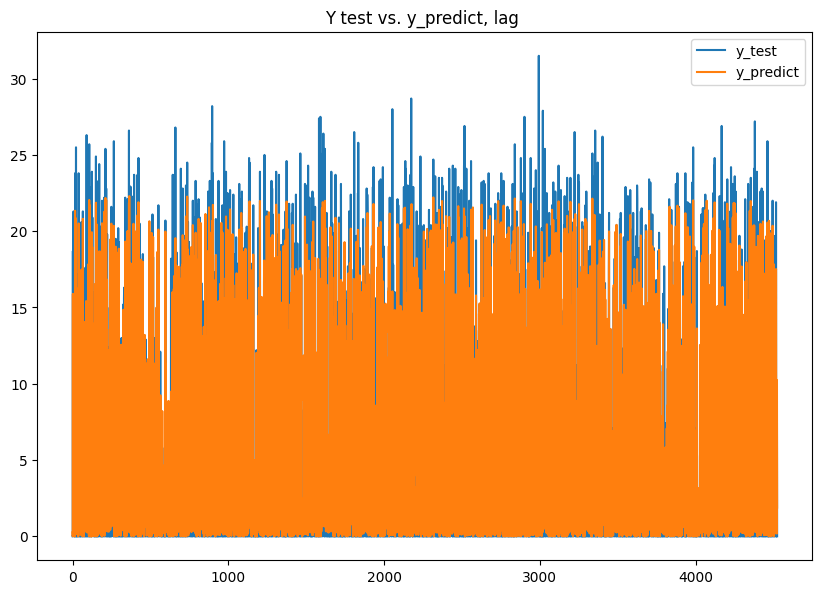

Epoch 1/10
1131/1131 [==============================] - 5s 3ms/step - loss: 31.6353 - val_loss: 15.8014
Epoch 2/10
1131/1131 [==============================] - 4s 3ms/step - loss: 13.3137 - val_loss: 9.5339
Epoch 3/10
1131/1131 [==============================] - 4s 4ms/step - loss: 10.4765 - val_loss: 8.4075
Epoch 4/10
1131/1131 [==============================] - 4s 3ms/step - loss: 9.7454 - val_loss: 7.9241
Epoch 5/10
1131/1131 [==============================] - 3s 3ms/step - loss: 9.4195 - val_loss: 8.1667
Epoch 6/10
1131/1131 [==============================] - 3s 3ms/step - loss: 9.3986 - val_loss: 7.9598
Epoch 7/10
1131/1131 [==============================] - 3s 3ms/step - loss: 9.0427 - val_loss: 7.2258
Epoch 8/10
1131/1131 [==============================] - 3s 3ms/step - loss: 8.7413 - val_loss: 7.5650
Epoch 9/10
1131/1131 [==============================] - 3s 3ms/step - loss: 8.6576 - val_loss: 7.2062
Epoch 10/10
1131/1131 [==============================] - 3s 3ms/step - loss: 8

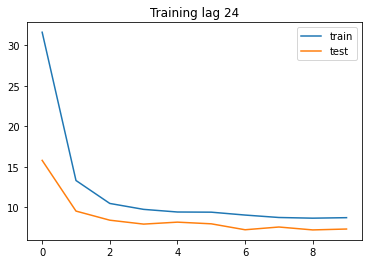

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Mean Square Error      = 7.31097184038933
Root Mean Square Error = 2.7038808850223655
Mean Absolute Error    = 1.352223296778377
Median Absolute Error  = 0.39469754695892334
R^2                    = 0.8485938265110878
Adjusted R^2           = 0.8476845812521464


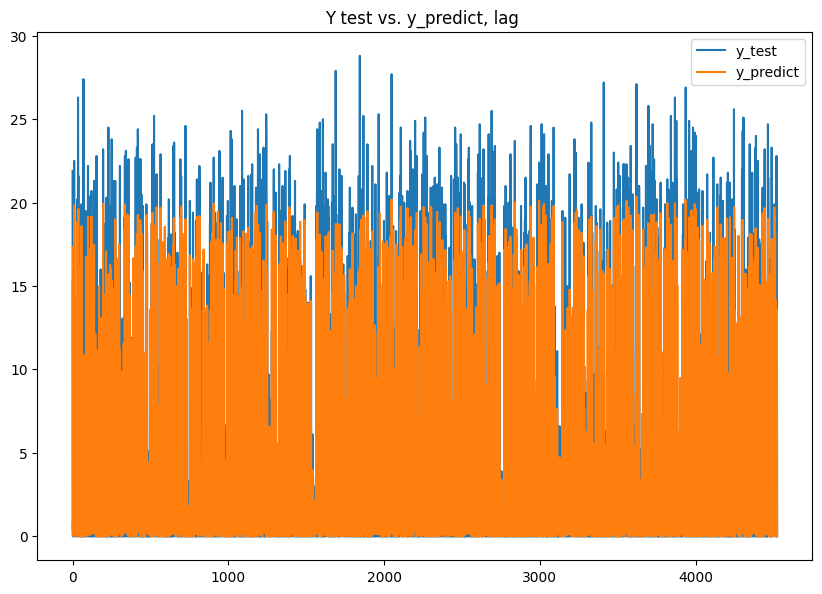

Epoch 1/10
1131/1131 [==============================] - 6s 4ms/step - loss: 977.0328 - val_loss: 823.5721
Epoch 2/10
1131/1131 [==============================] - 4s 3ms/step - loss: 629.2319 - val_loss: 535.1275
Epoch 3/10
1131/1131 [==============================] - 3s 3ms/step - loss: 429.1673 - val_loss: 376.1156
Epoch 4/10
1131/1131 [==============================] - 3s 3ms/step - loss: 324.0219 - val_loss: 291.0661
Epoch 5/10
1131/1131 [==============================] - 3s 3ms/step - loss: 270.9278 - val_loss: 245.1679
Epoch 6/10
1131/1131 [==============================] - 3s 3ms/step - loss: 238.7885 - val_loss: 218.0840
Epoch 7/10
1131/1131 [==============================] - 4s 3ms/step - loss: 219.1289 - val_loss: 199.0589
Epoch 8/10
1131/1131 [==============================] - 3s 3ms/step - loss: 207.1442 - val_loss: 191.0845
Epoch 9/10
1131/1131 [==============================] - 4s 3ms/step - loss: 199.8866 - val_loss: 182.8785
Epoch 10/10
1131/1131 [=======================

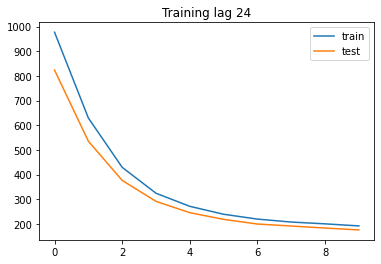

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Mean Square Error      = 175.06596030792423
Root Mean Square Error = 13.231249385750546
Mean Absolute Error    = 6.882785723011226
Median Absolute Error  = 2.4274783611297615
R^2                    = 0.8207578452393259
Adjusted R^2           = 0.8196814355021066


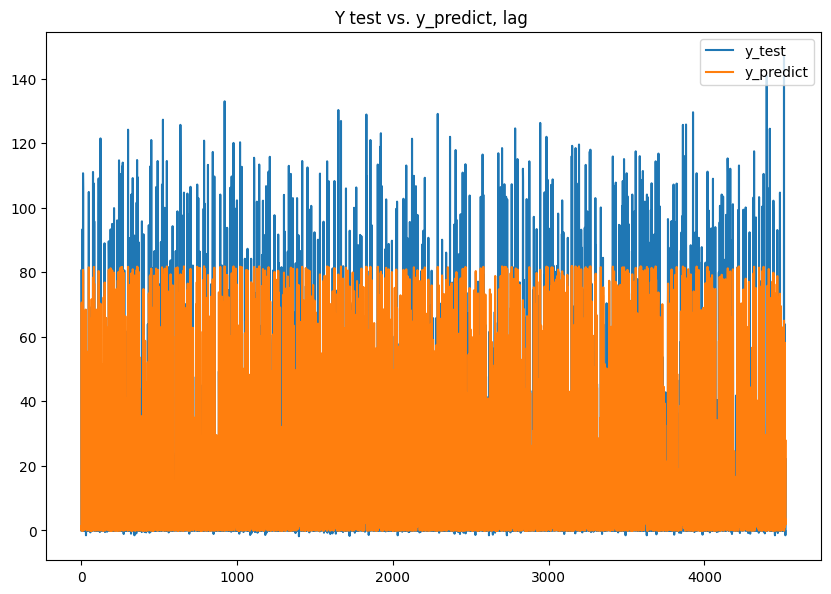

Epoch 1/10
1131/1131 [==============================] - 6s 4ms/step - loss: 14.1277 - val_loss: 7.2424
Epoch 2/10
1131/1131 [==============================] - 3s 3ms/step - loss: 6.7760 - val_loss: 5.1517
Epoch 3/10
1131/1131 [==============================] - 4s 3ms/step - loss: 5.7956 - val_loss: 4.8347
Epoch 4/10
1131/1131 [==============================] - 4s 3ms/step - loss: 5.4814 - val_loss: 4.5641
Epoch 5/10
1131/1131 [==============================] - 3s 3ms/step - loss: 5.4146 - val_loss: 4.4875
Epoch 6/10
1131/1131 [==============================] - 3s 3ms/step - loss: 5.2898 - val_loss: 4.6145
Epoch 7/10
1131/1131 [==============================] - 4s 3ms/step - loss: 5.2576 - val_loss: 4.4965
Epoch 8/10
1131/1131 [==============================] - 3s 3ms/step - loss: 5.1990 - val_loss: 4.4541
Epoch 9/10
1131/1131 [==============================] - 3s 3ms/step - loss: 5.1535 - val_loss: 4.3473
Epoch 10/10
1131/1131 [==============================] - 4s 3ms/step - loss: 5.11

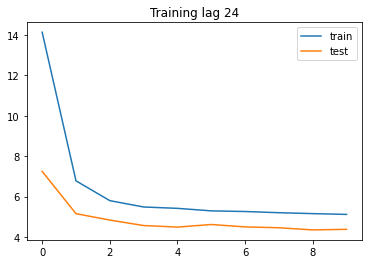

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Mean Square Error      = 4.375370443549931
Root Mean Square Error = 2.0917386174065657
Mean Absolute Error    = 1.0829109533106092
Median Absolute Error  = 0.27286947965621966
R^2                    = 0.8065966940860848
Adjusted R^2           = 0.8054352418486125


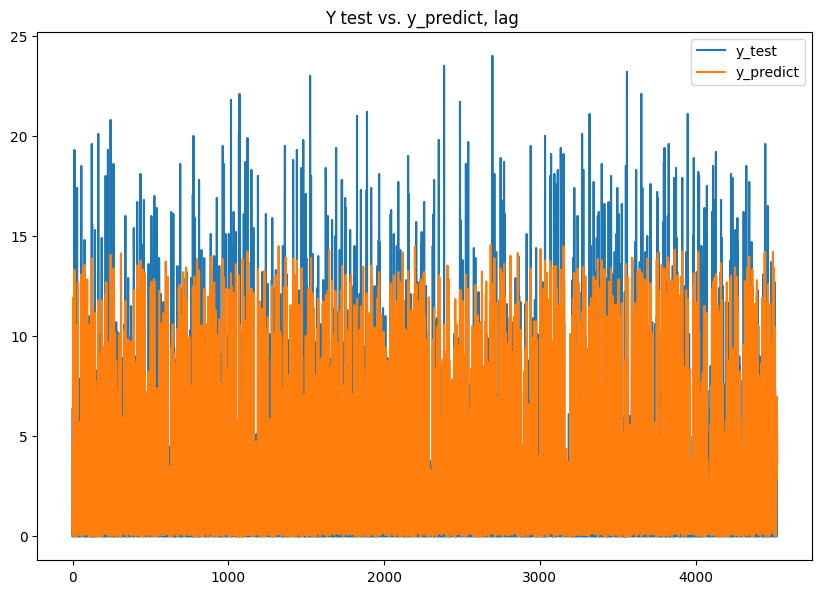

Epoch 1/10
1131/1131 [==============================] - 7s 5ms/step - loss: 75.7215 - val_loss: 41.2889
Epoch 2/10
1131/1131 [==============================] - 4s 3ms/step - loss: 28.8326 - val_loss: 20.1473
Epoch 3/10
1131/1131 [==============================] - 4s 3ms/step - loss: 20.9896 - val_loss: 16.7319
Epoch 4/10
1131/1131 [==============================] - 4s 3ms/step - loss: 19.3259 - val_loss: 15.8695
Epoch 5/10
1131/1131 [==============================] - 3s 3ms/step - loss: 18.3612 - val_loss: 15.3677
Epoch 6/10
1131/1131 [==============================] - 4s 3ms/step - loss: 17.8935 - val_loss: 15.0007
Epoch 7/10
1131/1131 [==============================] - 3s 3ms/step - loss: 17.5791 - val_loss: 14.8585
Epoch 8/10
1131/1131 [==============================] - 4s 3ms/step - loss: 17.4146 - val_loss: 14.6494
Epoch 9/10
1131/1131 [==============================] - 3s 3ms/step - loss: 17.3062 - val_loss: 14.6614
Epoch 10/10
1131/1131 [==============================] - 4s 3ms/

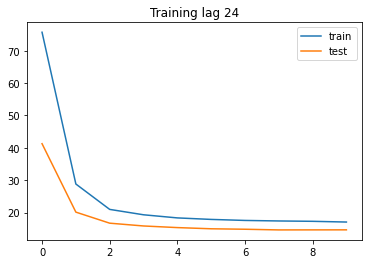

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Mean Square Error      = 14.648418042591953
Root Mean Square Error = 3.8273251811927285
Mean Absolute Error    = 1.8852668222972084
Median Absolute Error  = 0.5279265642166138
R^2                    = 0.8593310394081864
Adjusted R^2           = 0.8584862747427107


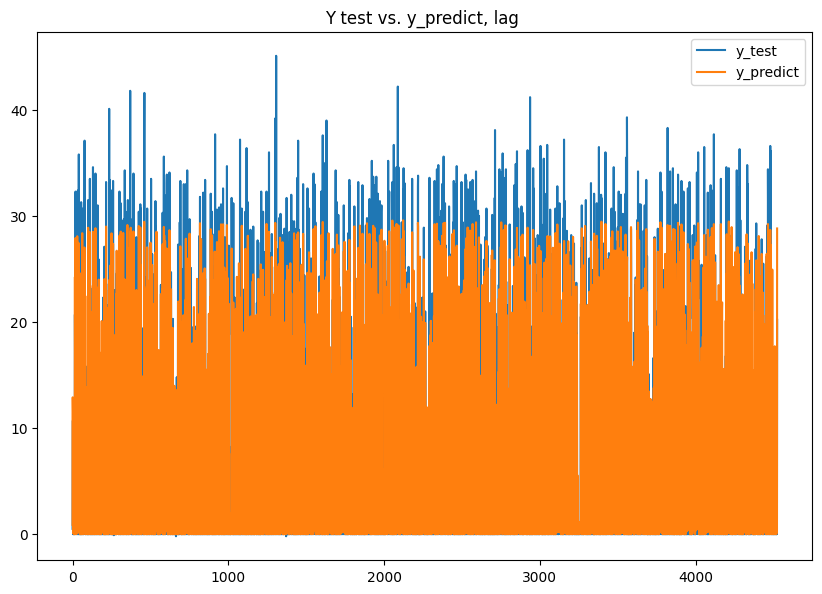

In [51]:
output = {}
for building in data_csv: 
    output[building] = LSTM_model(building, X_train[building], y_train[building], X_test[building], y_test[building])

In [ ]:
LSTM_model(X_train,y_train, X_test,y_test)

In [23]:
X_test

array([[[ 0.,  0.,  0., ..., 10.,  6., 16.]],

       [[ 0.,  0.,  0., ..., 14.,  9., 13.]],

       [[ 0.,  0.,  0., ..., 21.,  2.,  8.]],

       ...,

       [[ 0.,  0.,  0., ..., 12.,  5., 14.]],

       [[ 0.,  0.,  0., ..., 14.,  4., 15.]],

       [[ 0.,  0.,  0., ...,  9.,  1., 29.]]])

Test w/ different parameter

Epoch 1/30
1131/1131 [==============================] - 28s 22ms/step - loss: 28.6660 - val_loss: 13.3646
Epoch 2/30
1131/1131 [==============================] - 6s 5ms/step - loss: 15.5559 - val_loss: 12.6425
Epoch 3/30
1131/1131 [==============================] - 6s 5ms/step - loss: 15.0303 - val_loss: 12.2878
Epoch 4/30
1131/1131 [==============================] - 6s 5ms/step - loss: 14.5845 - val_loss: 11.9851
Epoch 5/30
1131/1131 [==============================] - 6s 5ms/step - loss: 14.2790 - val_loss: 12.0073
Epoch 6/30
1131/1131 [==============================] - 6s 5ms/step - loss: 14.0898 - val_loss: 12.1222
Epoch 7/30
1131/1131 [==============================] - 6s 5ms/step - loss: 13.9594 - val_loss: 11.9257
Epoch 8/30
1131/1131 [==============================] - 6s 5ms/step - loss: 13.7273 - val_loss: 11.7928
Epoch 9/30
1131/1131 [==============================] - 6s 6ms/step - loss: 13.6367 - val_loss: 11.6070
Epoch 10/30
1131/1131 [==============================] - 6s 5m

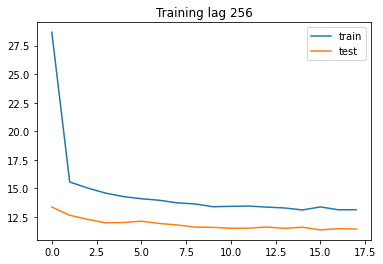

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Mean Square Error      = 11.395039902769927
Root Mean Square Error = 3.3756539963050014
Mean Absolute Error    = 1.5929500149808342
Median Absolute Error  = 0.27113856077194143
R^2                    = 0.8820887005195959
Adjusted R^2           = 0.8813806033029653


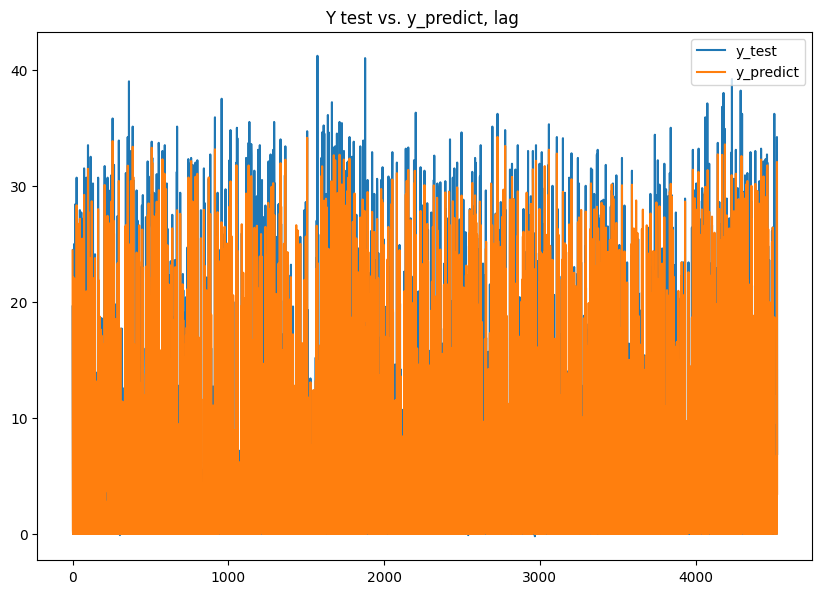

Epoch 1/30
1074/1074 [==============================] - 9s 6ms/step - loss: 72.1587 - val_loss: 49.9536
Epoch 2/30
1074/1074 [==============================] - 6s 5ms/step - loss: 50.4178 - val_loss: 47.1441
Epoch 3/30
1074/1074 [==============================] - 6s 5ms/step - loss: 48.4991 - val_loss: 45.9810
Epoch 4/30
1074/1074 [==============================] - 6s 6ms/step - loss: 47.7230 - val_loss: 45.3908
Epoch 5/30
1074/1074 [==============================] - 6s 6ms/step - loss: 46.1741 - val_loss: 45.0432
Epoch 6/30
1074/1074 [==============================] - 6s 6ms/step - loss: 45.2793 - val_loss: 44.5151
Epoch 7/30
1074/1074 [==============================] - 6s 6ms/step - loss: 45.3814 - val_loss: 44.3079
Epoch 8/30
1074/1074 [==============================] - 6s 6ms/step - loss: 44.2607 - val_loss: 44.4499
Epoch 9/30
1074/1074 [==============================] - 6s 6ms/step - loss: 43.3887 - val_loss: 44.0980
Epoch 10/30
1074/1074 [==============================] - 7s 6ms/

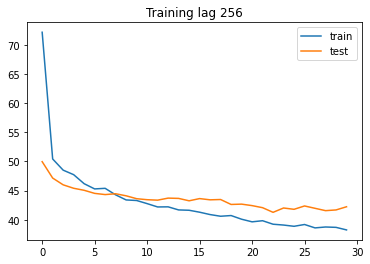

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Mean Square Error      = 43.22594099325853
Root Mean Square Error = 6.5746437921197325
Mean Absolute Error    = 2.9055205950752816
Median Absolute Error  = 0.2720360815525055
R^2                    = 0.676058242369312
Adjusted R^2           = 0.6740089388416577


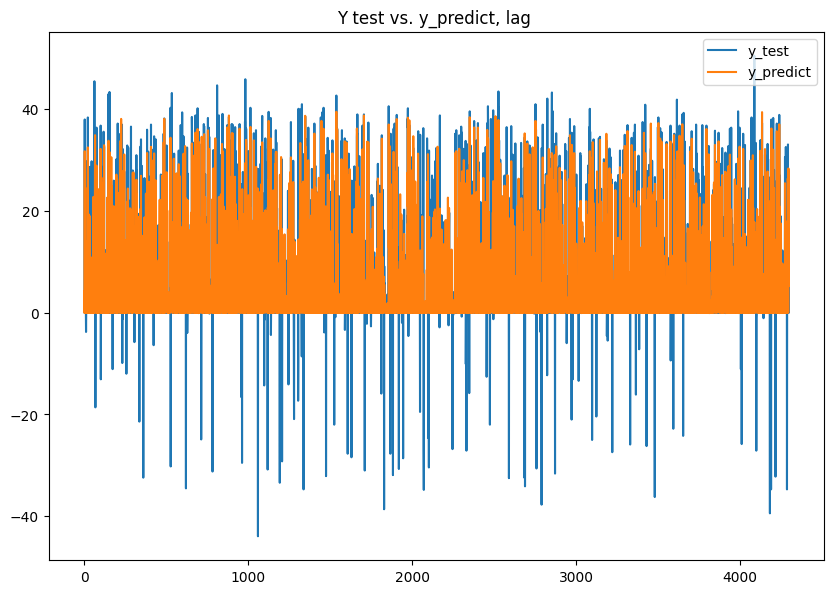

Epoch 1/30
1131/1131 [==============================] - 9s 6ms/step - loss: 25.6888 - val_loss: 14.9049
Epoch 2/30
1131/1131 [==============================] - 6s 6ms/step - loss: 16.3693 - val_loss: 14.7427
Epoch 3/30
1131/1131 [==============================] - 6s 5ms/step - loss: 15.7176 - val_loss: 14.2219
Epoch 4/30
1131/1131 [==============================] - 6s 5ms/step - loss: 15.3963 - val_loss: 14.2043
Epoch 5/30
1131/1131 [==============================] - 7s 6ms/step - loss: 15.1797 - val_loss: 14.4524
Epoch 6/30
1131/1131 [==============================] - 7s 6ms/step - loss: 15.0479 - val_loss: 14.7604
Epoch 7/30
1131/1131 [==============================] - 7s 6ms/step - loss: 14.9200 - val_loss: 14.8300
Epoch 8/30
1131/1131 [==============================] - 6s 6ms/step - loss: 14.7056 - val_loss: 13.9611
Epoch 9/30
1131/1131 [==============================] - 8s 7ms/step - loss: 14.5857 - val_loss: 13.7423
Epoch 10/30
1131/1131 [==============================] - 7s 6ms/

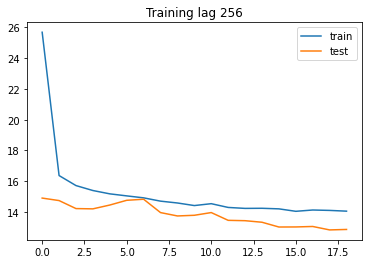

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Mean Square Error      = 12.833674994102637
Root Mean Square Error = 3.582411896209401
Mean Absolute Error    = 1.7651158217831484
Median Absolute Error  = 0.3
R^2                    = 0.8146065733031239
Adjusted R^2           = 0.8134932230983162


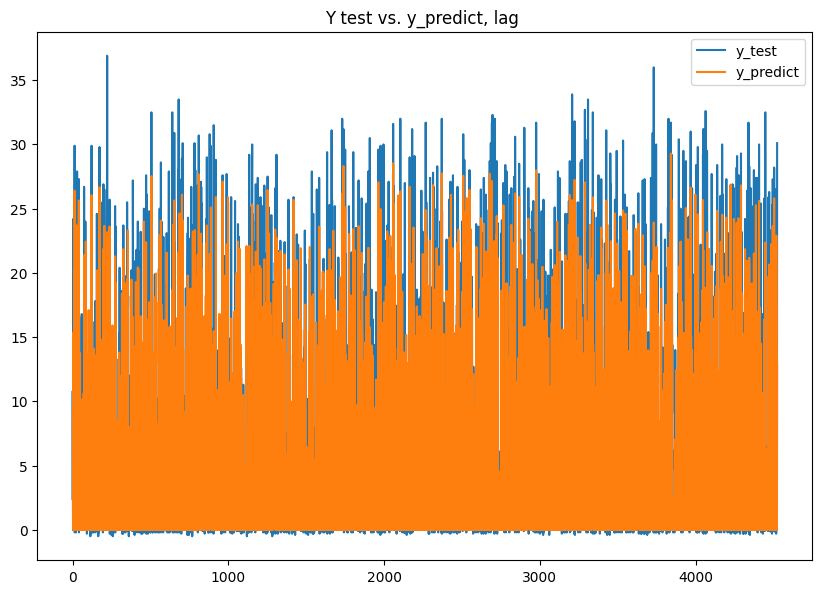

Epoch 1/30
1131/1131 [==============================] - 9s 7ms/step - loss: 2.6151 - val_loss: 1.3778
Epoch 2/30
1131/1131 [==============================] - 7s 6ms/step - loss: 1.5870 - val_loss: 1.4220
Epoch 3/30
1131/1131 [==============================] - 7s 6ms/step - loss: 1.5157 - val_loss: 1.2977
Epoch 4/30
1131/1131 [==============================] - 6s 6ms/step - loss: 1.4803 - val_loss: 1.2962
Epoch 5/30
1131/1131 [==============================] - 6s 6ms/step - loss: 1.4716 - val_loss: 1.3094
Epoch 6/30
1131/1131 [==============================] - 7s 6ms/step - loss: 1.4312 - val_loss: 1.2784
Epoch 7/30
1131/1131 [==============================] - 7s 7ms/step - loss: 1.4162 - val_loss: 1.2720
Epoch 8/30
1131/1131 [==============================] - 7s 6ms/step - loss: 1.4070 - val_loss: 1.2692
Epoch 9/30
1131/1131 [==============================] - 7s 6ms/step - loss: 1.3894 - val_loss: 1.2596
Epoch 10/30
1131/1131 [==============================] - 7s 6ms/step - loss: 1.393

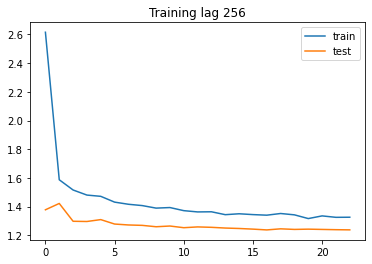

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Mean Square Error      = 1.2353573342208635
Root Mean Square Error = 1.111466299183589
Mean Absolute Error    = 0.5127560330612484
Median Absolute Error  = 0.09919679164886475
R^2                    = 0.8840844748065285
Adjusted R^2           = 0.883388362889219


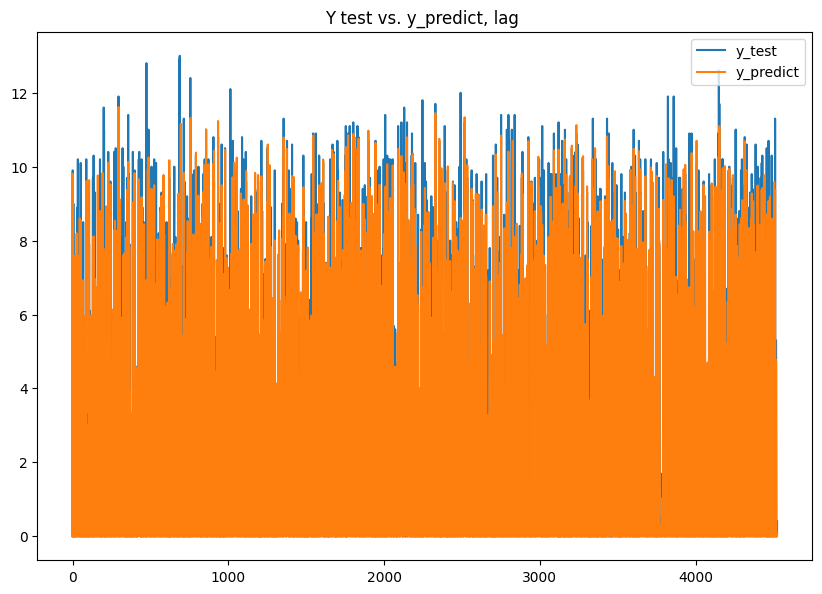

Epoch 1/30
1131/1131 [==============================] - 9s 7ms/step - loss: 24.4402 - val_loss: 11.1421
Epoch 2/30
1131/1131 [==============================] - 6s 6ms/step - loss: 12.4512 - val_loss: 10.3804
Epoch 3/30
1131/1131 [==============================] - 7s 6ms/step - loss: 11.9208 - val_loss: 10.3962
Epoch 4/30
1131/1131 [==============================] - 7s 6ms/step - loss: 11.8085 - val_loss: 10.1291
Epoch 5/30
1131/1131 [==============================] - 9s 8ms/step - loss: 11.4636 - val_loss: 10.0982
Epoch 6/30
1131/1131 [==============================] - 9s 8ms/step - loss: 11.3336 - val_loss: 9.8849
Epoch 7/30
1131/1131 [==============================] - 7s 6ms/step - loss: 11.2286 - val_loss: 9.8944
Epoch 8/30
1131/1131 [==============================] - 7s 6ms/step - loss: 11.1479 - val_loss: 9.9652
Epoch 9/30
1131/1131 [==============================] - 6s 5ms/step - loss: 11.0159 - val_loss: 9.7541
Epoch 10/30
1131/1131 [==============================] - 7s 6ms/step

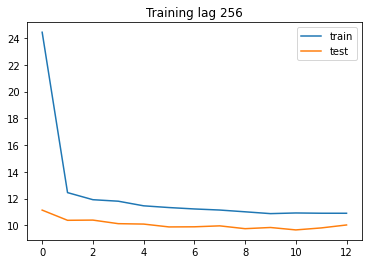

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Mean Square Error      = 10.026646945143193
Root Mean Square Error = 3.16648810911129
Mean Absolute Error    = 1.553835573777965
Median Absolute Error  = 0.4480799585580826
R^2                    = 0.8787508836810377
Adjusted R^2           = 0.8780227417458482


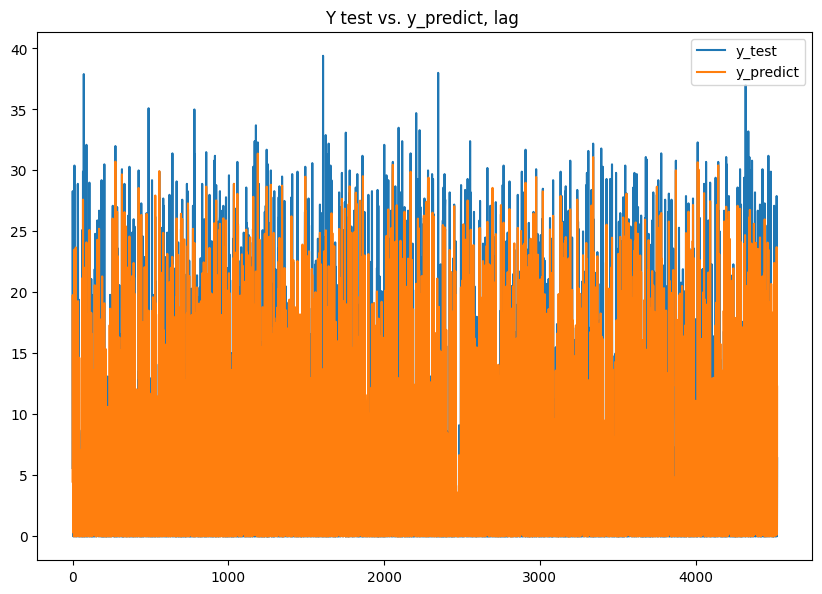

Epoch 1/30
1074/1074 [==============================] - 9s 7ms/step - loss: 375.3284 - val_loss: 249.9023
Epoch 2/30
1074/1074 [==============================] - 6s 6ms/step - loss: 245.3102 - val_loss: 225.0855
Epoch 3/30
1074/1074 [==============================] - 6s 6ms/step - loss: 233.9001 - val_loss: 218.8565
Epoch 4/30
1074/1074 [==============================] - 6s 6ms/step - loss: 228.5930 - val_loss: 216.6380
Epoch 5/30
1074/1074 [==============================] - 7s 6ms/step - loss: 223.7034 - val_loss: 214.5958
Epoch 6/30
1074/1074 [==============================] - 6s 6ms/step - loss: 220.9713 - val_loss: 211.6598
Epoch 7/30
1074/1074 [==============================] - 6s 6ms/step - loss: 219.5260 - val_loss: 209.8430
Epoch 8/30
1074/1074 [==============================] - 6s 6ms/step - loss: 216.5362 - val_loss: 208.6696
Epoch 9/30
1074/1074 [==============================] - 7s 7ms/step - loss: 213.6703 - val_loss: 205.6828
Epoch 10/30
1074/1074 [=======================

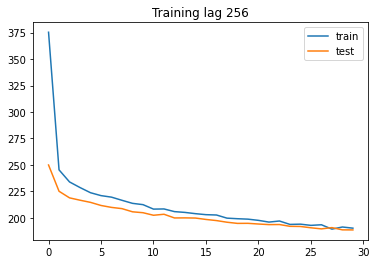

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Mean Square Error      = 198.5996411781219
Root Mean Square Error = 14.09253849305092
Mean Absolute Error    = 6.613524182140827
Median Absolute Error  = 1.288090801239014
R^2                    = 0.6623105234280591
Adjusted R^2           = 0.6601742497946377


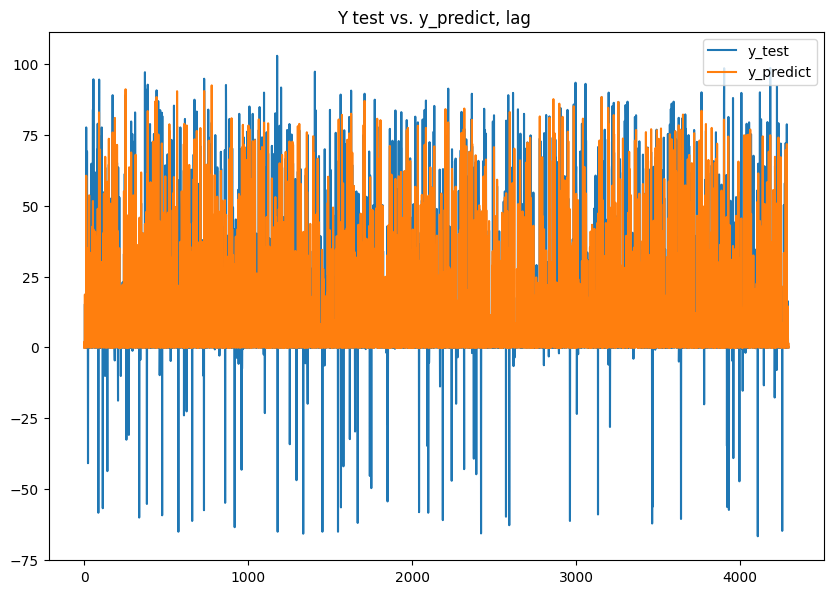

Epoch 1/30
1131/1131 [==============================] - 9s 7ms/step - loss: 67.0735 - val_loss: 25.7384
Epoch 2/30
1131/1131 [==============================] - 8s 7ms/step - loss: 31.0847 - val_loss: 24.8607
Epoch 3/30
1131/1131 [==============================] - 7s 6ms/step - loss: 30.0319 - val_loss: 24.3367
Epoch 4/30
1131/1131 [==============================] - 7s 6ms/step - loss: 29.4286 - val_loss: 24.5954
Epoch 5/30
1131/1131 [==============================] - 7s 6ms/step - loss: 29.0663 - val_loss: 25.0517
Epoch 6/30
1131/1131 [==============================] - 7s 6ms/step - loss: 28.6628 - val_loss: 24.0594
Epoch 7/30
1131/1131 [==============================] - 7s 6ms/step - loss: 28.2884 - val_loss: 24.1032
Epoch 8/30
1131/1131 [==============================] - 7s 6ms/step - loss: 28.3479 - val_loss: 23.5028
Epoch 9/30
1131/1131 [==============================] - 7s 6ms/step - loss: 27.7891 - val_loss: 23.5965
Epoch 10/30
1131/1131 [==============================] - 7s 6ms/

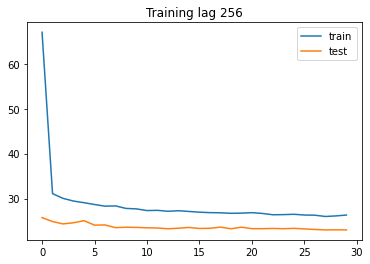

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Mean Square Error      = 22.947996141741037
Root Mean Square Error = 4.790406678116279
Mean Absolute Error    = 2.211211313242727
Median Absolute Error  = 0.42188150882720876
R^2                    = 0.8849634879289306
Adjusted R^2           = 0.8842726547825964


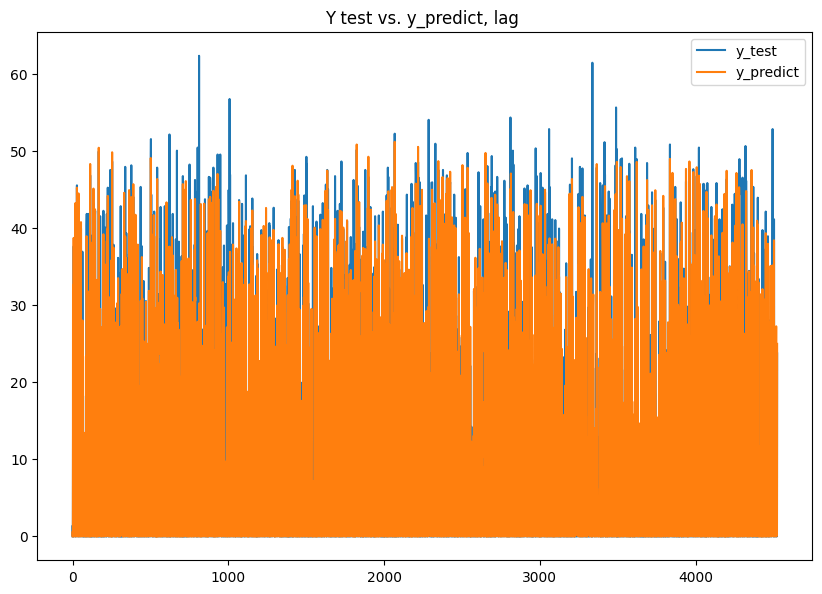

Epoch 1/30
1131/1131 [==============================] - 10s 7ms/step - loss: 283.7764 - val_loss: 135.5681
Epoch 2/30
1131/1131 [==============================] - 9s 8ms/step - loss: 114.4239 - val_loss: 123.3654
Epoch 3/30
1131/1131 [==============================] - 8s 7ms/step - loss: 108.7096 - val_loss: 126.5361
Epoch 4/30
1131/1131 [==============================] - 8s 7ms/step - loss: 106.9928 - val_loss: 123.1791
Epoch 5/30
1131/1131 [==============================] - 7s 6ms/step - loss: 105.8320 - val_loss: 118.7521
Epoch 6/30
1131/1131 [==============================] - 7s 6ms/step - loss: 104.1333 - val_loss: 120.1641
Epoch 7/30
1131/1131 [==============================] - 8s 7ms/step - loss: 102.0529 - val_loss: 124.7587
Epoch 8/30
1131/1131 [==============================] - 9s 8ms/step - loss: 102.7141 - val_loss: 117.7958
Epoch 9/30
1131/1131 [==============================] - 7s 6ms/step - loss: 101.5201 - val_loss: 116.8193
Epoch 10/30
1131/1131 [======================

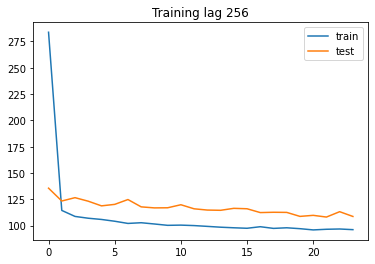

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Mean Square Error      = 108.0632818739909
Root Mean Square Error = 10.3953490501277
Mean Absolute Error    = 4.710921350628744
Median Absolute Error  = 0.3645964801311493
R^2                    = 0.8585120395642153
Adjusted R^2           = 0.8576623565277904


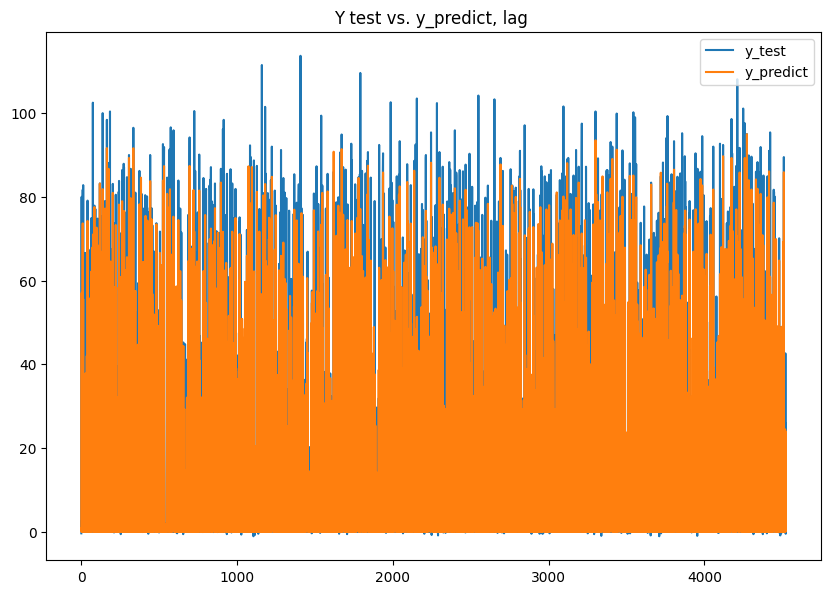

Epoch 1/30
1131/1131 [==============================] - 10s 8ms/step - loss: 77.6590 - val_loss: 30.6218
Epoch 2/30
1131/1131 [==============================] - 8s 7ms/step - loss: 35.3791 - val_loss: 29.3294
Epoch 3/30
1131/1131 [==============================] - 8s 7ms/step - loss: 34.5947 - val_loss: 29.0152
Epoch 4/30
1131/1131 [==============================] - 8s 7ms/step - loss: 33.7707 - val_loss: 28.6060
Epoch 5/30
1131/1131 [==============================] - 8s 7ms/step - loss: 33.4640 - val_loss: 28.0897
Epoch 6/30
1131/1131 [==============================] - 8s 7ms/step - loss: 32.7907 - val_loss: 28.3263
Epoch 7/30
1131/1131 [==============================] - 7s 6ms/step - loss: 32.4680 - val_loss: 28.1974
Epoch 8/30
1131/1131 [==============================] - 7s 6ms/step - loss: 32.3113 - val_loss: 27.5166
Epoch 9/30
1131/1131 [==============================] - 7s 6ms/step - loss: 31.8026 - val_loss: 28.0789
Epoch 10/30
1131/1131 [==============================] - 10s 9m

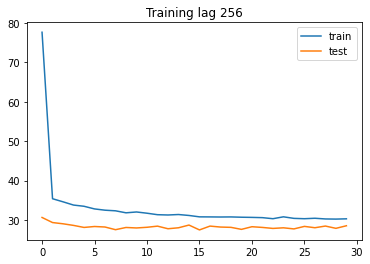

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Mean Square Error      = 28.507566858924875
Root Mean Square Error = 5.339247780251903
Mean Absolute Error    = 2.665754637372483
Median Absolute Error  = 0.8472630381584167
R^2                    = 0.8814320171345741
Adjusted R^2           = 0.8807199763122061


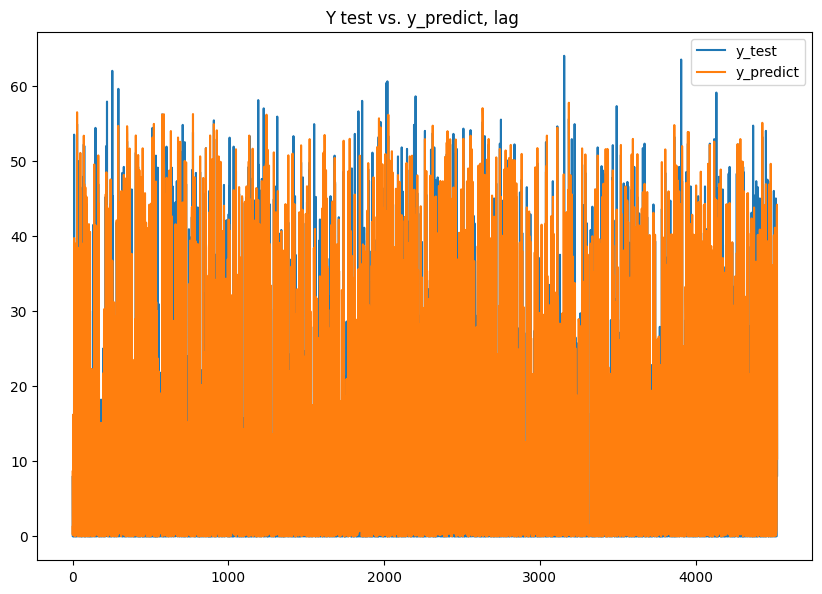

Epoch 1/30
1131/1131 [==============================] - 10s 7ms/step - loss: 14.4624 - val_loss: 6.7251
Epoch 2/30
1131/1131 [==============================] - 7s 6ms/step - loss: 7.9582 - val_loss: 6.3730
Epoch 3/30
1131/1131 [==============================] - 7s 6ms/step - loss: 7.6194 - val_loss: 6.3208
Epoch 4/30
1131/1131 [==============================] - 8s 7ms/step - loss: 7.3788 - val_loss: 6.5089
Epoch 5/30
1131/1131 [==============================] - 8s 7ms/step - loss: 7.3904 - val_loss: 6.2301
Epoch 6/30
1131/1131 [==============================] - 7s 6ms/step - loss: 7.2366 - val_loss: 6.2086
Epoch 7/30
1131/1131 [==============================] - 7s 7ms/step - loss: 7.0933 - val_loss: 6.1822
Epoch 8/30
1131/1131 [==============================] - 7s 6ms/step - loss: 7.0035 - val_loss: 6.1780
Epoch 9/30
1131/1131 [==============================] - 7s 6ms/step - loss: 7.0490 - val_loss: 6.3262
Epoch 10/30
1131/1131 [==============================] - 7s 6ms/step - loss: 7.0

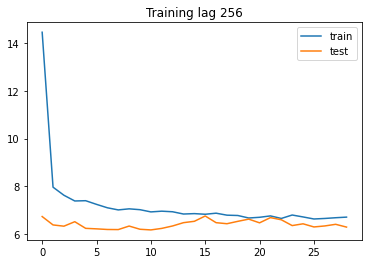

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Mean Square Error      = 6.281747908473501
Root Mean Square Error = 2.506341538672154
Mean Absolute Error    = 1.432240797095758
Median Absolute Error  = 0.7077879428863527
R^2                    = 0.8814403054841708
Adjusted R^2           = 0.8807283144361443


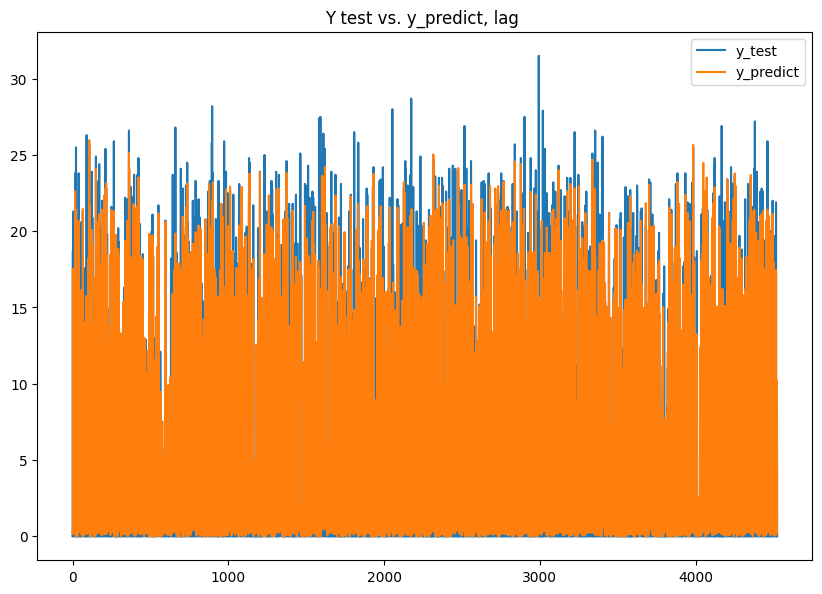

Epoch 1/30
1131/1131 [==============================] - 10s 7ms/step - loss: 14.3432 - val_loss: 7.6703
Epoch 2/30
1131/1131 [==============================] - 8s 7ms/step - loss: 8.6202 - val_loss: 7.4928
Epoch 3/30
1131/1131 [==============================] - 7s 7ms/step - loss: 8.3005 - val_loss: 7.5299
Epoch 4/30
1131/1131 [==============================] - 8s 7ms/step - loss: 8.0523 - val_loss: 7.3732
Epoch 5/30
1131/1131 [==============================] - 7s 6ms/step - loss: 7.8022 - val_loss: 7.3911
Epoch 6/30
1131/1131 [==============================] - 9s 8ms/step - loss: 7.7794 - val_loss: 7.2281
Epoch 7/30
1131/1131 [==============================] - 8s 7ms/step - loss: 7.6576 - val_loss: 7.1144
Epoch 8/30
1131/1131 [==============================] - 8s 7ms/step - loss: 7.7055 - val_loss: 7.2322
Epoch 9/30
1131/1131 [==============================] - 7s 7ms/step - loss: 7.6207 - val_loss: 7.0502
Epoch 10/30
1131/1131 [==============================] - 8s 7ms/step - loss: 7.4

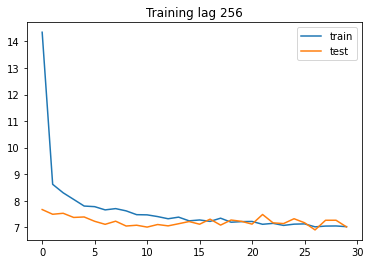

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Mean Square Error      = 6.989766435025612
Root Mean Square Error = 2.6438166417181077
Mean Absolute Error    = 1.2445598452176592
Median Absolute Error  = 0.1800477981567381
R^2                    = 0.8552458123745001
Adjusted R^2           = 0.8543765145395605


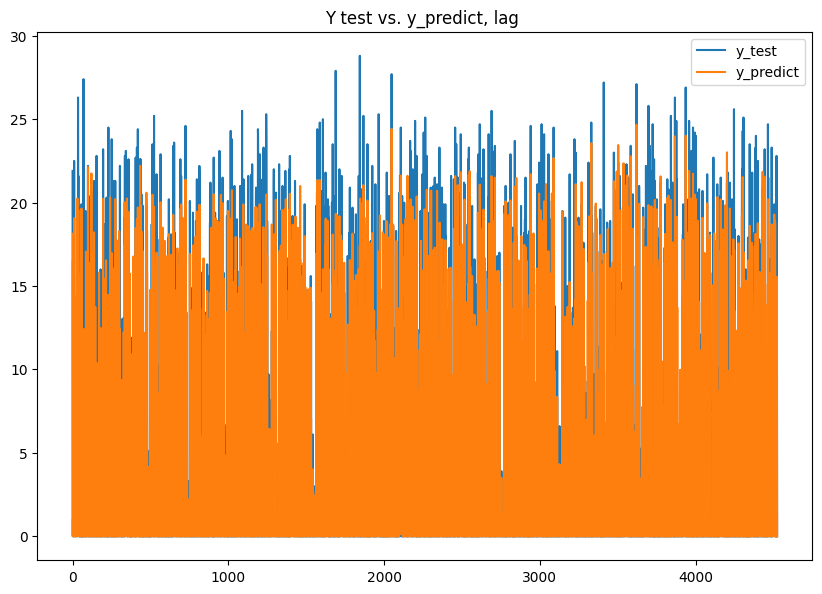

Epoch 1/30
1131/1131 [==============================] - 10s 7ms/step - loss: 398.8506 - val_loss: 188.4732
Epoch 2/30
1131/1131 [==============================] - 7s 6ms/step - loss: 164.1053 - val_loss: 168.2263
Epoch 3/30
1131/1131 [==============================] - 8s 7ms/step - loss: 154.2248 - val_loss: 165.3295
Epoch 4/30
1131/1131 [==============================] - 7s 6ms/step - loss: 151.0331 - val_loss: 159.2612
Epoch 5/30
1131/1131 [==============================] - 7s 7ms/step - loss: 148.3002 - val_loss: 155.1621
Epoch 6/30
1131/1131 [==============================] - 7s 7ms/step - loss: 146.1908 - val_loss: 152.5056
Epoch 7/30
1131/1131 [==============================] - 8s 7ms/step - loss: 143.3381 - val_loss: 153.6280
Epoch 8/30
1131/1131 [==============================] - 7s 7ms/step - loss: 142.1406 - val_loss: 151.9192
Epoch 9/30
1131/1131 [==============================] - 7s 6ms/step - loss: 140.1782 - val_loss: 151.4213
Epoch 10/30
1131/1131 [======================

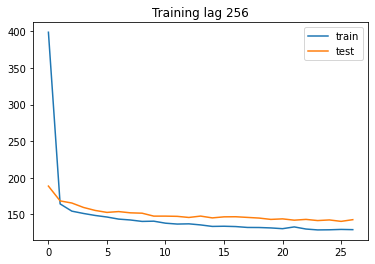

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Mean Square Error      = 141.7407739121157
Root Mean Square Error = 11.905493434214128
Mean Absolute Error    = 5.309934752744768
Median Absolute Error  = 0.4
R^2                    = 0.8548780031893889
Adjusted R^2           = 0.8540064965359444


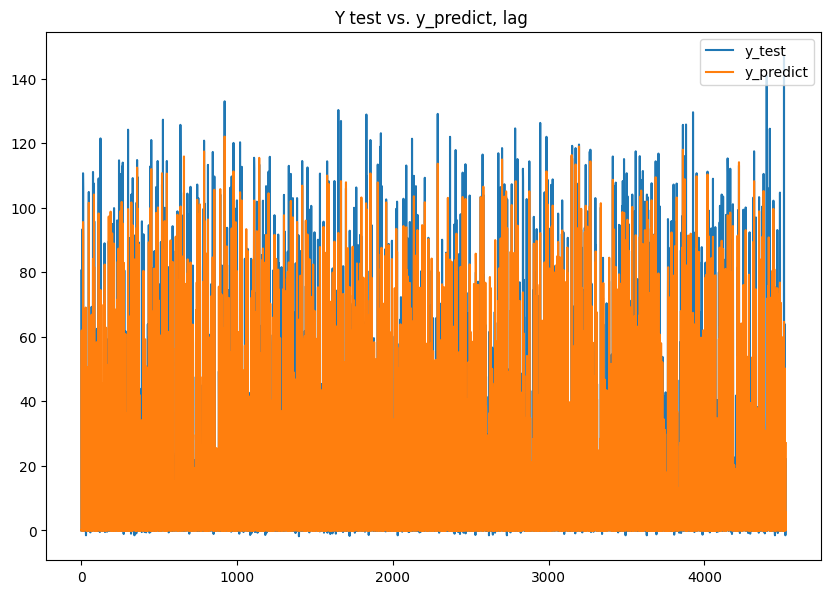

Epoch 1/30
1131/1131 [==============================] - 10s 8ms/step - loss: 7.3109 - val_loss: 4.6930
Epoch 2/30
1131/1131 [==============================] - 8s 7ms/step - loss: 5.0383 - val_loss: 4.6266
Epoch 3/30
1131/1131 [==============================] - 7s 6ms/step - loss: 4.9171 - val_loss: 4.5109
Epoch 4/30
1131/1131 [==============================] - 7s 6ms/step - loss: 4.7891 - val_loss: 4.7858
Epoch 5/30
1131/1131 [==============================] - 7s 6ms/step - loss: 4.7000 - val_loss: 4.4278
Epoch 6/30
1131/1131 [==============================] - 8s 7ms/step - loss: 4.6919 - val_loss: 4.3699
Epoch 7/30
1131/1131 [==============================] - 7s 7ms/step - loss: 4.6273 - val_loss: 4.4326
Epoch 8/30
1131/1131 [==============================] - 8s 7ms/step - loss: 4.6468 - val_loss: 4.3943
Epoch 9/30
1131/1131 [==============================] - 8s 7ms/step - loss: 4.6399 - val_loss: 4.6483
Epoch 10/30
1131/1131 [==============================] - 7s 6ms/step - loss: 4.62

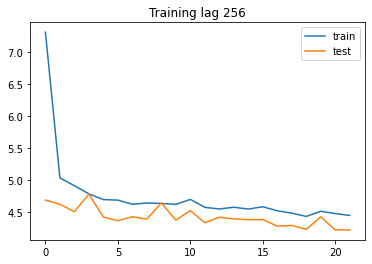

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Mean Square Error      = 4.223631326467015
Root Mean Square Error = 2.0551475193929547
Mean Absolute Error    = 0.9904685295531962
Median Absolute Error  = 0.13270756602287292
R^2                    = 0.8133039768770899
Adjusted R^2           = 0.8121828041403643


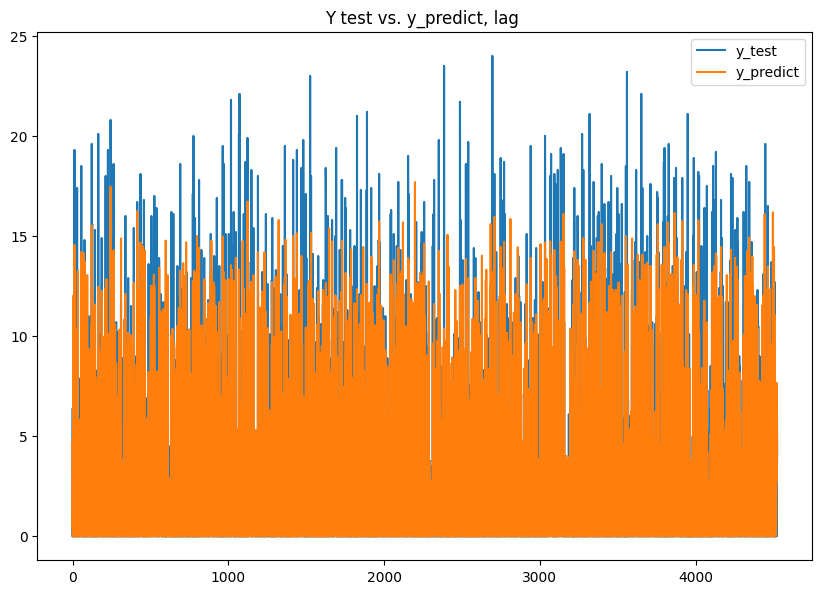

Epoch 1/30
1131/1131 [==============================] - 9s 7ms/step - loss: 29.4675 - val_loss: 16.4267
Epoch 2/30
1131/1131 [==============================] - 7s 7ms/step - loss: 16.2116 - val_loss: 15.1081
Epoch 3/30
1131/1131 [==============================] - 8s 7ms/step - loss: 15.5794 - val_loss: 15.2649
Epoch 4/30
1131/1131 [==============================] - 9s 8ms/step - loss: 15.3457 - val_loss: 14.9092
Epoch 5/30
1131/1131 [==============================] - 9s 8ms/step - loss: 15.0310 - val_loss: 14.5724
Epoch 6/30
1131/1131 [==============================] - 8s 7ms/step - loss: 14.9023 - val_loss: 14.8762
Epoch 7/30
1131/1131 [==============================] - 8s 7ms/step - loss: 14.7849 - val_loss: 14.4255
Epoch 8/30
1131/1131 [==============================] - 7s 6ms/step - loss: 14.6088 - val_loss: 14.3676
Epoch 9/30
1131/1131 [==============================] - 8s 7ms/step - loss: 14.6411 - val_loss: 14.3603
Epoch 10/30
1131/1131 [==============================] - 8s 7ms/

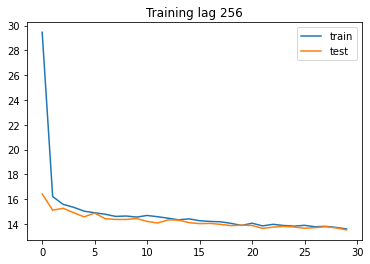

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Mean Square Error      = 13.475642053275969
Root Mean Square Error = 3.6709184209508074
Mean Absolute Error    = 1.746776475046558
Median Absolute Error  = 0.3633281201124195
R^2                    = 0.870593223416346
Adjusted R^2           = 0.8698160919733392


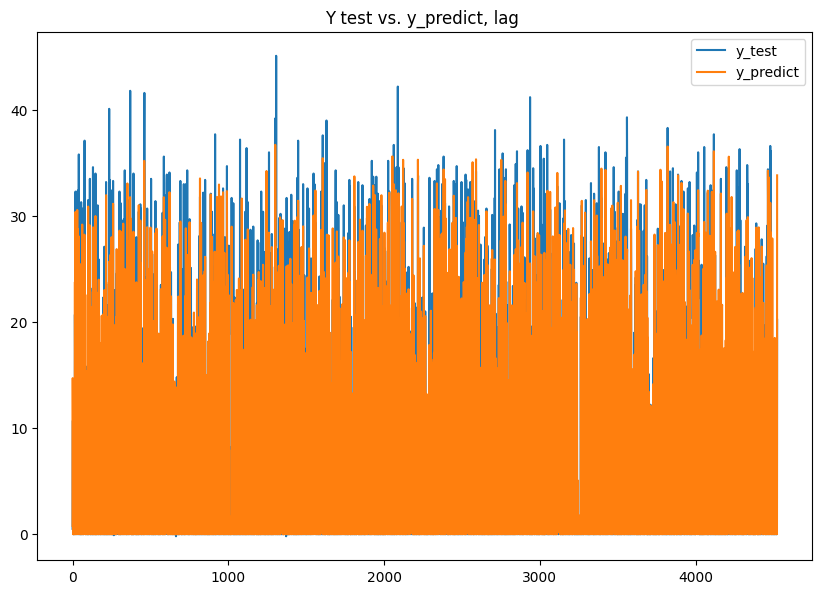

In [55]:
batch_size_ = 12
dropout_ =0.33
epochs_ = 30
samples = 256


for building in data_csv: 
    output[building] = LSTM_model(building, X_train[building], y_train[building], X_test[building], y_test[building],
                                  batch_size_,
                                  dropout_,
                                  epochs_,
                                  samples)

In [57]:
model_results['중앙도서관']

[{'Algo': 'LSTM',
  'batch_size': 12,
  'dropout': 0.3,
  'epochs': 10,
  'lag': 24,
  'loss': {'loss': [32.54867172241211,
    12.039103507995605,
    9.927373886108398,
    9.4322509765625,
    8.867433547973633,
    8.437607765197754,
    8.489015579223633,
    8.46623706817627,
    8.217894554138184,
    8.221714973449707],
   'val_loss': [14.925073623657227,
    7.78175687789917,
    7.366087436676025,
    7.096611022949219,
    7.101994037628174,
    7.11763858795166,
    6.550638198852539,
    6.347635269165039,
    6.461645126342773,
    6.643789768218994]},
  'model_filename': '1660047567_model_24_lag.h5',
  'power_gen_rmse': 2.5773542646014866,
  'r2': 0.8746267733691275,
  'rmse': 6.6427550052594695,
  'time_ran': 1660047569},
 {'Algo': 'LSTM',
  'batch_size': 12,
  'dropout': 0.33,
  'epochs': 30,
  'lag': 256,
  'loss': {'loss': [14.46243953704834,
    7.9581756591796875,
    7.619406700134277,
    7.378823757171631,
    7.390427589416504,
    7.236598014831543,
    7.0933

In [58]:
new_res_df = {}

for b in data_csv:
    new_res_df[b] = pd.DataFrame(model_results[b])

In [59]:
new_res_df['학생회관']

,Algo,lag,dropout,epochs,batch_size,loss,rmse,power_gen_rmse,r2,model_filename,time_ran
0,LSTM,24,0.30,10,12,"{'loss': [75.72154998779297, 28.83264541625976...",14.648418,3.827325,0.859331,1660047740_model_24_lag.h5,1660047741
1,LSTM,256,0.33,30,12,"{'loss': [29.467470169067383, 16.2115631103515...",13.475642,3.670918,0.870593,1660052167_model_256_lag.h5,1660052169


In [62]:
models_by_r2 = {}
for b in data_csv:
    models_by_r2[b] = new_res_df[b].sort_values(by='r2', ascending=False)

models_by_r2['학생회관']

,Algo,lag,dropout,epochs,batch_size,loss,rmse,power_gen_rmse,r2,model_filename,time_ran
1,LSTM,256,0.33,30,12,"{'loss': [29.467470169067383, 16.2115631103515...",13.475642,3.670918,0.870593,1660052167_model_256_lag.h5,1660052169
0,LSTM,24,0.30,10,12,"{'loss': [75.72154998779297, 28.83264541625976...",14.648418,3.827325,0.859331,1660047740_model_24_lag.h5,1660047741


In [63]:
model = {}
for b in data_csv:
    model_filename = models_by_r2[b]['model_filename'].iloc[0]
    if(model_filename.endswith('.pkl')):
        model[b] = joblib.load('./models/'+ b +"/"+ model_filename)
    else:
        model[b] = load_model('./models/'+b+"/"+ model_filename)

# Forecast 8/1/2022


In [65]:
PATH = "/content/OBS_ASOS_TIM_20220809021430.csv"
df_forecast = pd.read_csv(PATH, encoding="euc_kr")
df_forecast.head()

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),습도(%),증기압(hPa),이슬점온도(°C),일조(hr),일사(MJ/m2),전운량(10분위)
0,156,광주,2022-08-01 00:00,26.0,7.5,3.2,99,33.2,25.8,NaN,NaN,10
1,156,광주,2022-08-01 01:00,26.5,0.3,4.1,99,34.2,26.3,NaN,NaN,10
2,156,광주,2022-08-01 02:00,27.2,0.0,4.5,99,35.6,27.0,NaN,NaN,8
3,156,광주,2022-08-01 03:00,27.3,NaN,3.9,99,35.9,27.1,NaN,NaN,8
4,156,광주,2022-08-01 04:00,27.2,0.0,3.8,99,35.6,27.0,NaN,NaN,10


In [66]:
df_forecast = df_forecast.drop(axis=1, columns=['지점', '지점명'])
df_forecast["일시"] = pd.to_datetime(df_forecast["일시"])

In [67]:
df_forecast = df_forecast[:24]

In [68]:
df_forecast

,일시,기온(°C),강수량(mm),풍속(m/s),습도(%),증기압(hPa),이슬점온도(°C),일조(hr),일사(MJ/m2),전운량(10분위)
0,2022-08-01 00:00:00,26.0,7.5,3.2,99,33.2,25.8,NaN,NaN,10
1,2022-08-01 01:00:00,26.5,0.3,4.1,99,34.2,26.3,NaN,NaN,10
2,2022-08-01 02:00:00,27.2,0.0,4.5,99,35.6,27.0,NaN,NaN,8
3,2022-08-01 03:00:00,27.3,NaN,3.9,99,35.9,27.1,NaN,NaN,8
4,2022-08-01 04:00:00,27.2,0.0,3.8,99,35.6,27.0,NaN,NaN,10
5,2022-08-01 05:00:00,26.4,0.4,2.8,99,34.0,26.2,NaN,NaN,10
6,2022-08-01 06:00:00,25.8,0.1,2.1,99,32.8,25.6,0.0,0.06,10
7,2022-08-01 07:00:00,25.7,0.7,1.5,99,32.6,25.5,0.0,0.11,10
8,2022-08-01 08:00:00,26.9,0.0,2.0,99,35.0,26.7,0.0,0.35,10
9,2022-08-01 09:00:00,27.9,NaN,1.4,99,37.1,27.7,0.1,0.93,7


In [69]:
df_forecast["일사(MJ/m2)"].fillna(0.0, inplace=True)
df_forecast["강수량(mm)"].fillna(0.0, inplace=True)
df_forecast["일조(hr)"].fillna(0.0, inplace=True)

In [70]:
df_forecast = df_forecast.assign(Cloud = lambda x: x['전운량(10분위)'] >= 5)

In [71]:
df_forecast = df_forecast.assign(Hour = lambda x: x['일시'].dt.hour)
df_forecast = df_forecast.assign(Month = lambda x: x['일시'].dt.month)
df_forecast = df_forecast.assign(Year = lambda x: x['일시'].dt.year)
df_forecast = df_forecast.assign(Day = lambda x: x['일시'].dt.day)

In [72]:
print(df_forecast['Hour'].unique())
Features_forecast_total = df_forecast['Hour']
enc = preprocessing.LabelEncoder()
enc.fit(Features_forecast_total)
Features_forecast_total = enc.transform(Features_forecast_total)
print(Features_forecast_total)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [73]:
ohe = preprocessing.OneHotEncoder()
encoded = ohe.fit(Features_forecast_total.reshape(-1,1))
print(Features_forecast_total.reshape(-1,1))
Features_forecast_total = encoded.transform(Features_forecast_total.reshape(-1,1)).toarray()
Features_forecast_total[:10,:]

[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]
 [19]
 [20]
 [21]
 [22]
 [23]]


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 

In [74]:
def encode_string(cat_feature):
    ## First encode the strings to numeric categories
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_feature)
    enc_cat_feature = enc.transform(cat_feature)
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(enc_cat_feature.reshape(-1,1))
    return encoded.transform(enc_cat_feature.reshape(-1,1)).toarray()
    

categorical_columns = ['Cloud']

for col in categorical_columns:
    temp = encode_string(df_forecast[col])
    Features_forecast_total = np.concatenate([Features_forecast_total, temp], axis = 1)
    #print(Features)

print(Features_forecast_total.shape)
print(Features_forecast_total[:2,:])  

(24, 26)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]]


In [75]:
Features_forecast_total = np.concatenate([Features_forecast_total, np.array(df_forecast[['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '증기압(hPa)', '이슬점온도(°C)',
       '일조(hr)', '일사(MJ/m2)', 'Hour', 'Month', 'Day']])], axis = 1)
Features_forecast_total[:2,:]

array([[ 1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  1. , 26. ,  7.5,  3.2, 99. , 33.2, 25.8,  0. ,
         0. ,  0. ,  8. ,  1. ],
       [ 0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  1. , 26.5,  0.3,  4.1, 99. , 34.2, 26.3,  0. ,
         0. ,  1. ,  8. ,  1. ]])

In [76]:
Features_forecast_total.shape

(24, 37)

In [77]:
scaler = preprocessing.StandardScaler().fit(Features_forecast_total[:,10:])
Features_forecast_total[:,10:] = scaler.transform(Features_forecast_total[:,10:])
print(Features_forecast_total.shape)
Features_forecast_total[:10,:]

(24, 37)


array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.20851441, -0.20851441, -0.20851441, -0.20851441, -0.20851441,
        -0.20851441, -0.20851441, -0.20851441, -0.20851441, -0.20851441,
        -0.20851441, -0.20851441, -0.20851441, -0.20851441, -0.20851441,
         0.20851441, -1.53872947,  4.76657946,  0.3074536 ,  0.70124089,
        -1.616262  , -1.64214233, -0.25548807, -0.86906725, -1.66132477,
         0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.20851441, -0.20851441, -0.20851441, -0.20851441, -0.20851441,
        -0.20851441, -0.20851441, -0.20851441, -0.20851441, -0.20851441,
        -0.20851441, -0.20851441, -0.20851441, -0.20851441, -0.20851441,
         0.20851441, -1.07595369, -0.05017452,  1.21717932,  0.70124089,
        -1.08342

In [41]:
Features_forecast_total.shape

(24, 37)

In [78]:
model_filename

'1660052167_model_256_lag.h5'

In [79]:
#if(model_filename.endswith('.h5')):
Features_forecast_total = Features_forecast_total.reshape((Features_forecast_total.shape[0], 1, Features_forecast_total.shape[1]))
    # make a prediction

res = {}

for d in data_csv:
    res[d] = model[d].predict(Features_forecast_total)
    # print(res)
    # sets floor for res
    res[d] = [x[0] if x > 0 else 0 for x in res[d]]
"""
else:
    # make a prediction
    res = model.predict(Features_forecast_total)
    # print(res)
    # sets floor for res
    res = [x if x > 0 else 0 for x in res]
"""

'\nelse:\n    # make a prediction\n    res = model.predict(Features_forecast_total)\n    # print(res)\n    # sets floor for res\n    res = [x if x > 0 else 0 for x in res]\n'

In [81]:
df_total = {}

for d in data_csv:
    df_total[d] = pd.concat([df_forecast, pd.DataFrame(res[d], columns=['predicted_power'], index=df_forecast.index)], axis=1)

,일시,기온(°C),강수량(mm),풍속(m/s),습도(%),증기압(hPa),이슬점온도(°C),일조(hr),일사(MJ/m2),전운량(10분위),Cloud,Hour,Month,Year,Day,predicted_power
0,2022-08-01 00:00:00,26.0,7.5,3.2,99,33.2,25.8,0.0,0.00,10,True,0,8,2022,1,0.000000
1,2022-08-01 01:00:00,26.5,0.3,4.1,99,34.2,26.3,0.0,0.00,10,True,1,8,2022,1,0.000000
2,2022-08-01 02:00:00,27.2,0.0,4.5,99,35.6,27.0,0.0,0.00,8,True,2,8,2022,1,0.000000
3,2022-08-01 03:00:00,27.3,0.0,3.9,99,35.9,27.1,0.0,0.00,8,True,3,8,2022,1,0.000000
4,2022-08-01 04:00:00,27.2,0.0,3.8,99,35.6,27.0,0.0,0.00,10,True,4,8,2022,1,0.000000
5,2022-08-01 05:00:00,26.4,0.4,2.8,99,34.0,26.2,0.0,0.00,10,True,5,8,2022,1,0.000000
6,2022-08-01 06:00:00,25.8,0.1,2.1,99,32.8,25.6,0.0,0.06,10,True,6,8,2022,1,0.000000
7,2022-08-01 07:00:00,25.7,0.7,1.5,99,32.6,25.5,0.0,0.11,10,True,7,8,2022,1,0.000000
8,2022-08-01 08:00:00,26.9,0.0,2.0,99,35.0,26.7,0.0,0.35,10,True,8,8,2022,1,0.000000
9,2022-08-01 09:00:00,27.9,0.0,1.4,99,37.1,27.7,0.1,0.93,7,True,9,8,2022,1,5.107127


In [82]:
df_total['LG도서관']

,일시,기온(°C),강수량(mm),풍속(m/s),습도(%),증기압(hPa),이슬점온도(°C),일조(hr),일사(MJ/m2),전운량(10분위),Cloud,Hour,Month,Year,Day,predicted_power
0,2022-08-01 00:00:00,26.0,7.5,3.2,99,33.2,25.8,0.0,0.00,10,True,0,8,2022,1,0.000000
1,2022-08-01 01:00:00,26.5,0.3,4.1,99,34.2,26.3,0.0,0.00,10,True,1,8,2022,1,0.000000
2,2022-08-01 02:00:00,27.2,0.0,4.5,99,35.6,27.0,0.0,0.00,8,True,2,8,2022,1,0.000000
3,2022-08-01 03:00:00,27.3,0.0,3.9,99,35.9,27.1,0.0,0.00,8,True,3,8,2022,1,0.000000
4,2022-08-01 04:00:00,27.2,0.0,3.8,99,35.6,27.0,0.0,0.00,10,True,4,8,2022,1,0.000000
5,2022-08-01 05:00:00,26.4,0.4,2.8,99,34.0,26.2,0.0,0.00,10,True,5,8,2022,1,0.000000
6,2022-08-01 06:00:00,25.8,0.1,2.1,99,32.8,25.6,0.0,0.06,10,True,6,8,2022,1,0.000000
7,2022-08-01 07:00:00,25.7,0.7,1.5,99,32.6,25.5,0.0,0.11,10,True,7,8,2022,1,0.000000
8,2022-08-01 08:00:00,26.9,0.0,2.0,99,35.0,26.7,0.0,0.35,10,True,8,8,2022,1,0.000000
9,2022-08-01 09:00:00,27.9,0.0,1.4,99,37.1,27.7,0.1,0.93,7,True,9,8,2022,1,5.107127


In [84]:
import os

for pred in df_total:
    os.makedirs("./outputs/"+pred)

In [85]:
for pred in df_total:
    df_total[pred].to_csv("./outputs/"+pred+"/prediction.csv")